## Importing required libraries

In [34]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns',100)
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
# Path to SQLite database
database_path = 'candidate_data.db'

# Create a connection to the SQLite database
conn = sqlite3.connect(database_path)

# SQL query to select all data from the training data table
query_train = "SELECT * FROM train_data"

# Load data from the SQL query into a pandas DataFrame
df_train = pd.read_sql_query(query_train, conn)

# SQL query to select all data from the testing data table
query_test = "SELECT * FROM test_data"

# Load data from the SQL query into a pandas DataFrame
df_test = pd.read_sql_query(query_test, conn)

# Close the connection to the database
conn.close()

## Cleaning Corrected Data

In [4]:
#Cleaning the data
df_train['name'] = df_train['name'].str.replace('\n','')
df_train['name'] = df_train['name'].str.strip()

## Null Value Imputation

In [5]:
#Null Value Imputation
df_train['job_role'].fillna('NA',inplace=True)
df_train['tags'].fillna('NA',inplace=True)
df_train['gold_badges'].fillna('NA',inplace=True)
df_train['silver_badges'].fillna('0',inplace=True)
df_train['bronze_badges'].fillna('0',inplace=True)
df_train['questions'].fillna('0',inplace=True)
df_train['answers'].fillna('0',inplace=True)
df_train['reputation'].fillna('0',inplace=True)
df_train['reached'].fillna('0',inplace=True)
df_train['posts_edited'].fillna('0',inplace=True)
df_train['votes_cast'].fillna('0',inplace=True)
df_train['helpful_tags'].fillna('0',inplace=True)

# DATA CLEANING

## 1. Remove , from all numerical columns

In [6]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']]=df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

## 2. Clean k and m values

In [7]:
df_train['reached'] = df_train['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_train['reached'] = df_train['reached'].apply(convert_k_to_num)

## 3. Cleaning Member_Since

In [8]:
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_train['member_since_in_months'] = df_train['member_since'].apply(convert_to_months)
df_train['member_since_in_months'] = df_train['member_since_in_months'].round(2)

## Type Casting

In [9]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

# Feature Engineering

## AI Engineer Skills

### programming languages - python
### machine learning - scikit-learn, statsmodels, machine-learning, regression
### neural network - deep-learning, pytorch, keras, tensorflow, neural-networks

In [10]:
df_train['weighted_badge_score'] = (3 * df_train['gold_badges']) + (2 * df_train['silver_badges']) + df_train['bronze_badges']
df_train['questions'] = np.where(df_train['questions']==0, 1, df_train['questions'])
df_train['QA_ratio'] = (df_train['answers']/df_train['questions']).round(2)

#dropping this because there's a weighted badge score
df_train.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

## Creating flags for all the skills

In [11]:
df_train['Programming_Language_Flag'] = np.where(df_train['tags'].str.contains('python'),1,0)
df_train['Machine_Learning_Flag'] = np.where(df_train['tags'].str.contains('scikit-learn|statsmodels|machine-learning|regression'),1,0)
df_train['Neural_Network_Flag'] = np.where(df_train['tags'].str.contains('deep-learning|pytorch|keras|tensorflow|neural-networks'),1,0)
df_train['Programming_Language_Flag'] = np.where((df_train['Machine_Learning_Flag']==1)|(df_train['Neural_Network_Flag']==1) , 1, df_train['Programming_Language_Flag'])
df_train['total_requirements_satisfied'] = df_train['Programming_Language_Flag']+df_train['Machine_Learning_Flag']+df_train['Neural_Network_Flag']

In [12]:
df_train.shape

(34279, 20)

## Shortlisting AI Engineers

In [15]:
df_train[~(((df_train['total_requirements_satisfied']==1)&(df_train['Programming_Language_Flag']==1))|(df_train['total_requirements_satisfied']==0))].shape

(816, 20)

In [16]:
df_train = df_train[~(((df_train['total_requirements_satisfied']==1)&(df_train['Programming_Language_Flag']==1))|(df_train['total_requirements_satisfied']==0))]

In [16]:
df_train.shape

(816, 21)

## Transformations

REPUTATION 

       Transformation      Skew
               Actual 14.165680
                  Log  0.270961
           Reciprocal  1.374079
Exponential power 0.2  1.427101
Exponential power 0.3  2.393666
          Square Root  5.123963
            Cube Root  2.773057
               Boxcox  0.043349

 Best Transformation for  reputation : 
 Boxcox = 0.04334860736639468


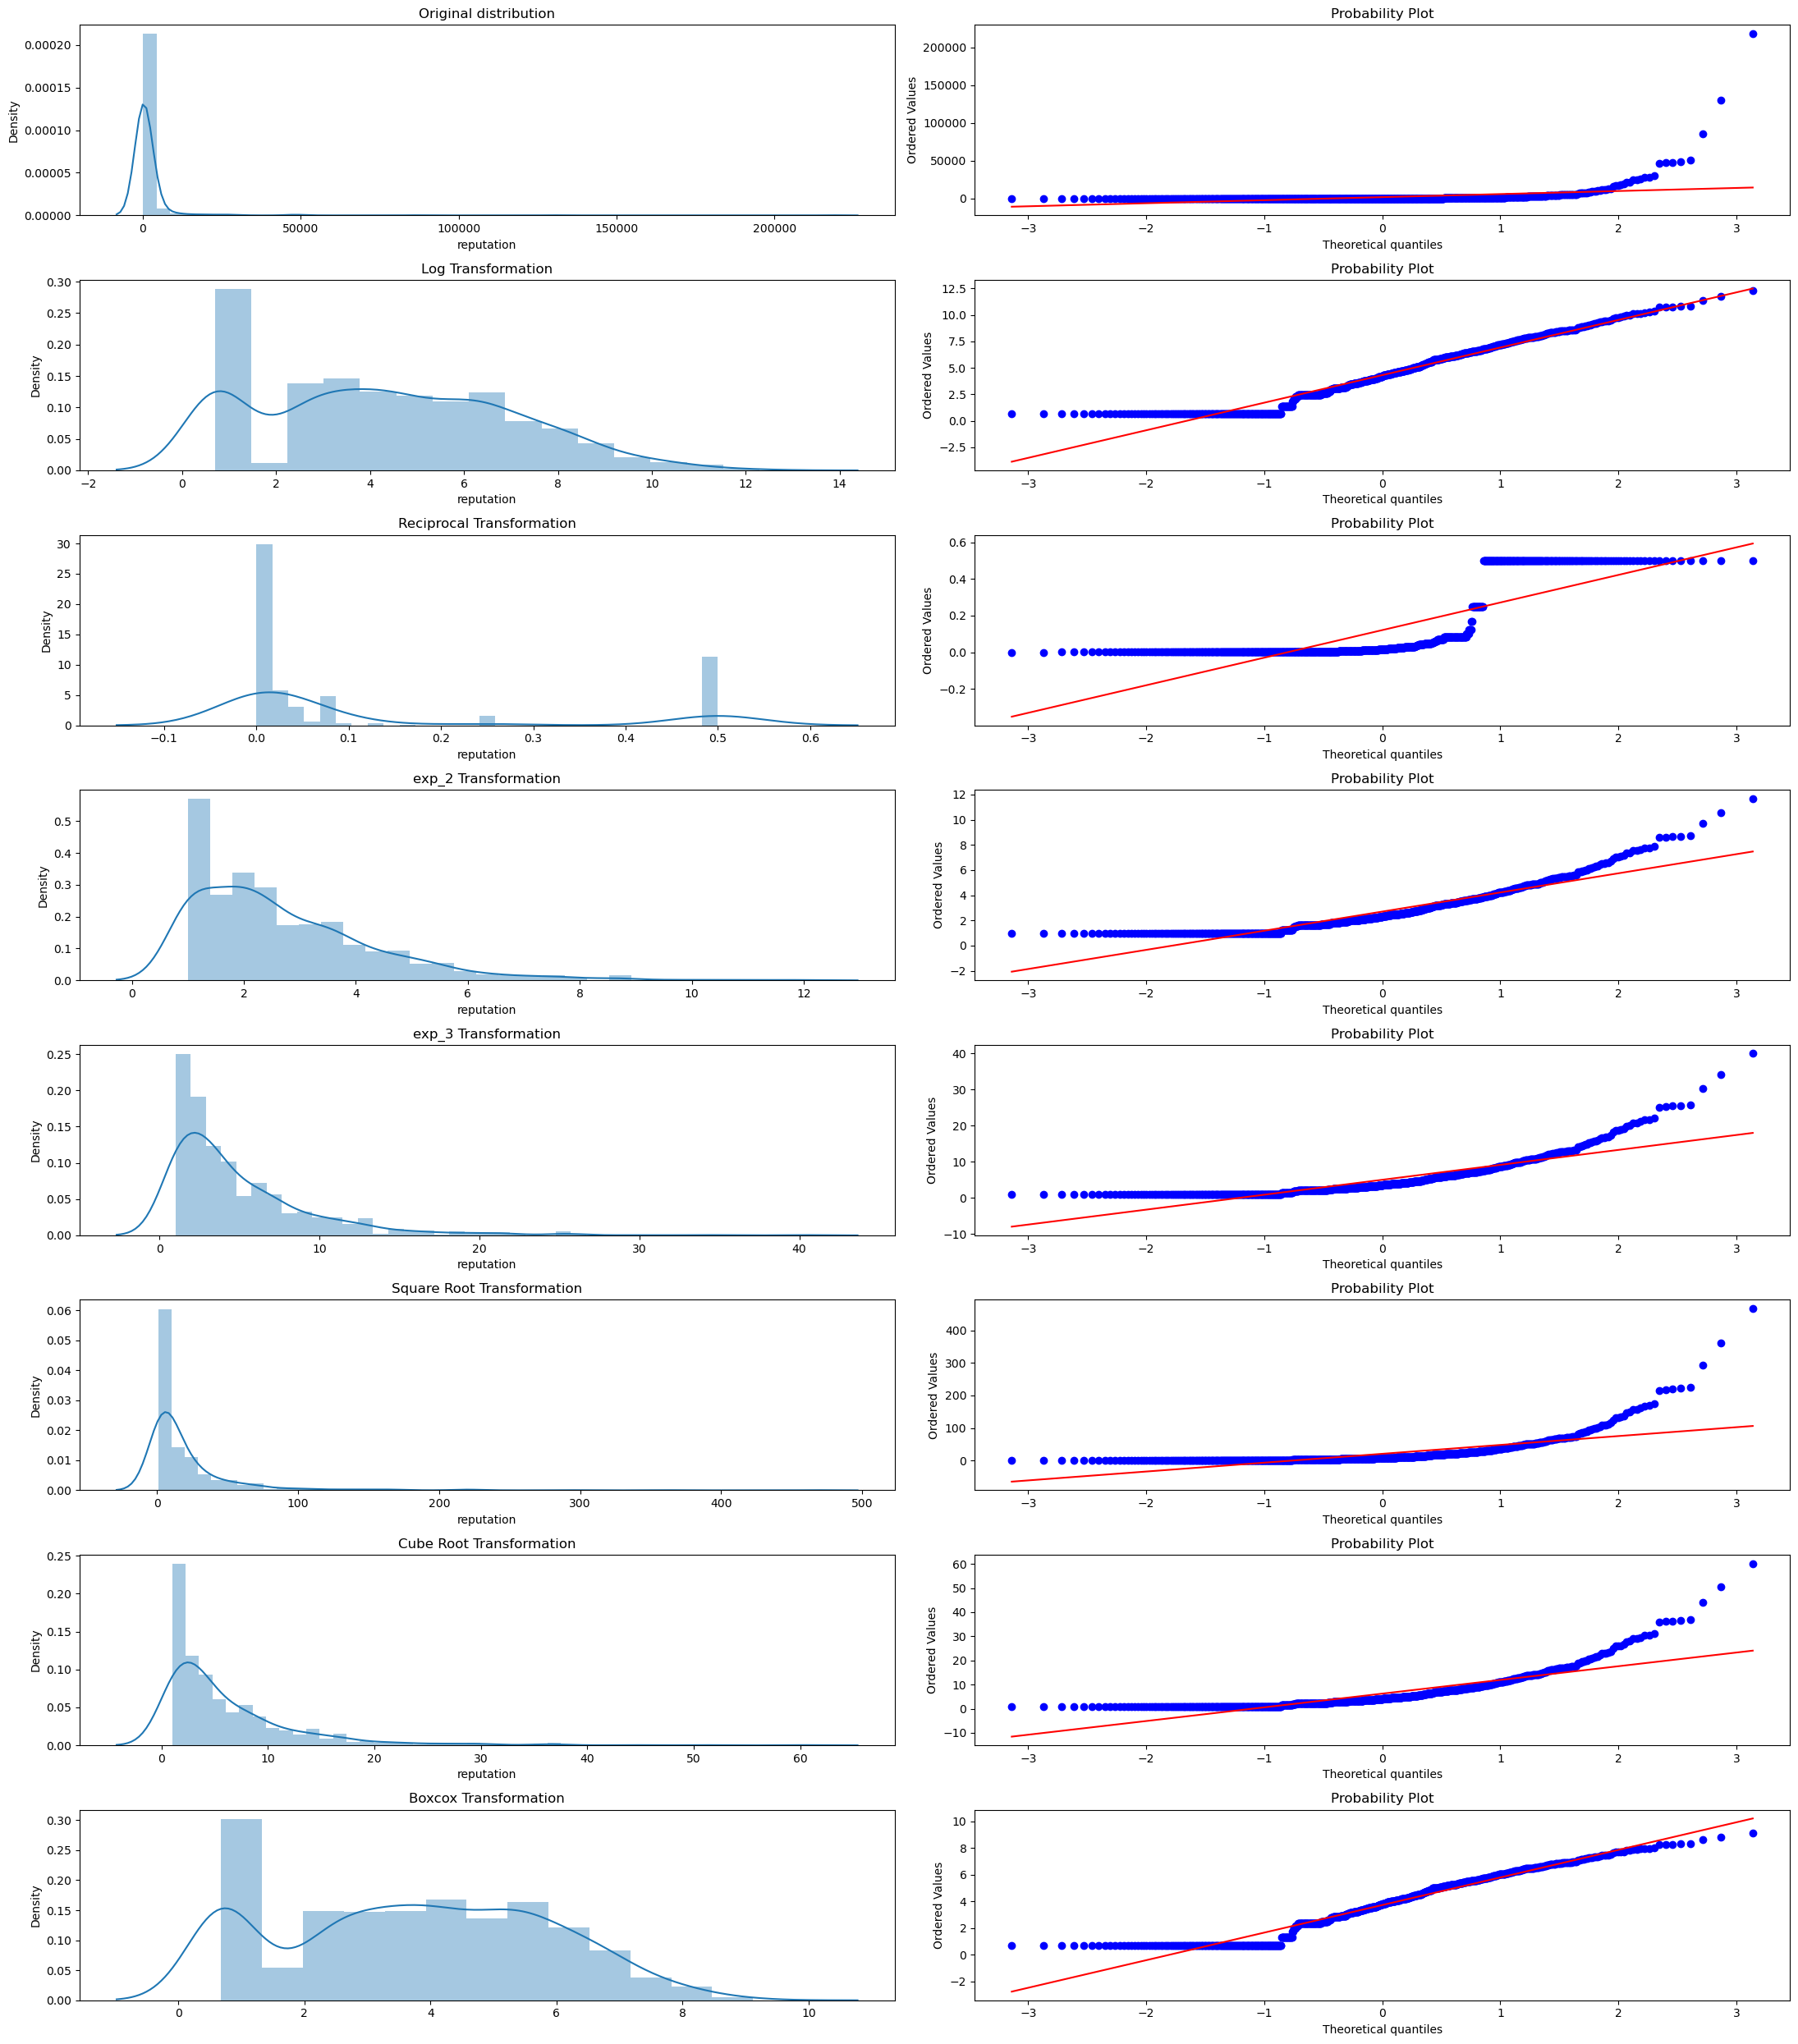

REACHED 

       Transformation      Skew
               Actual 16.339219
                  Log  0.116903
           Reciprocal 22.350847
Exponential power 0.2  1.728319
Exponential power 0.3  3.058000
          Square Root  7.240268
            Cube Root  3.615464
               Boxcox  0.017676

 Best Transformation for  reached : 
 Boxcox = 0.017675949047843538


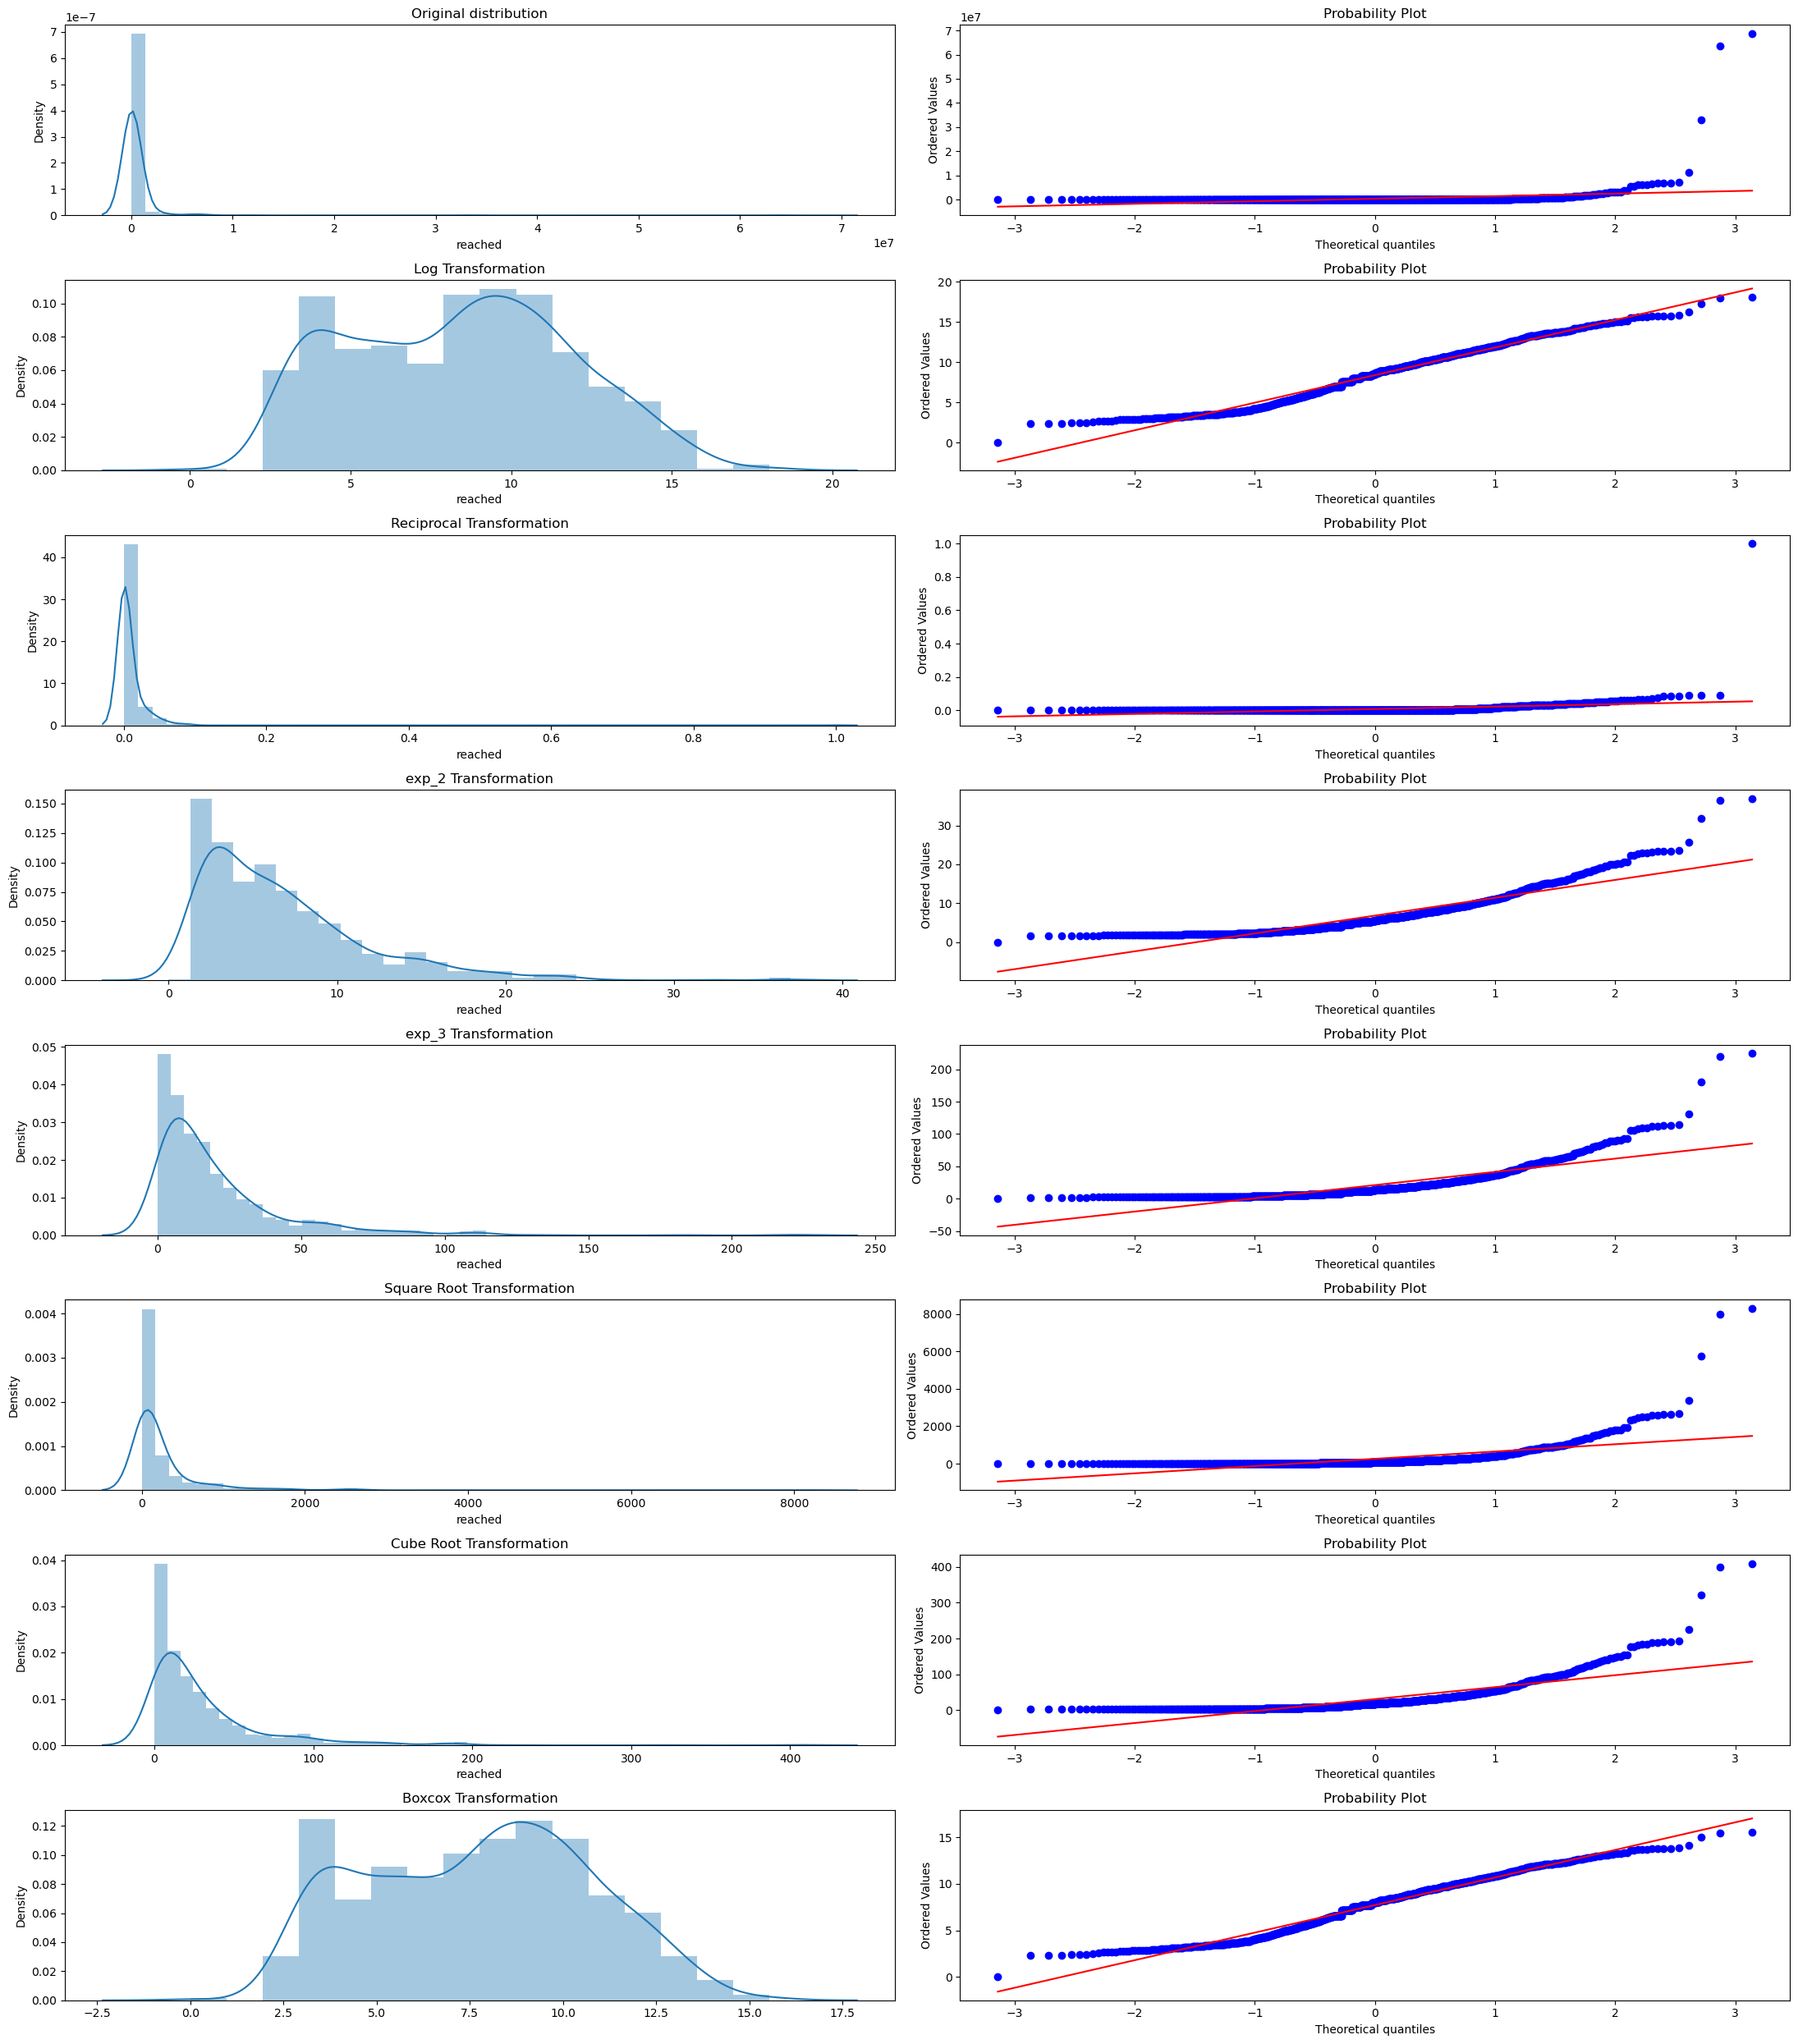

QUESTIONS 

       Transformation     Skew
               Actual 8.337857
                  Log 0.954905
           Reciprocal 0.490433
Exponential power 0.2 1.387068
Exponential power 0.3 1.850650
          Square Root 3.069700
            Cube Root 2.024630
               Boxcox 0.203018

 Best Transformation for  questions : 
 Boxcox = 0.20301808039296215


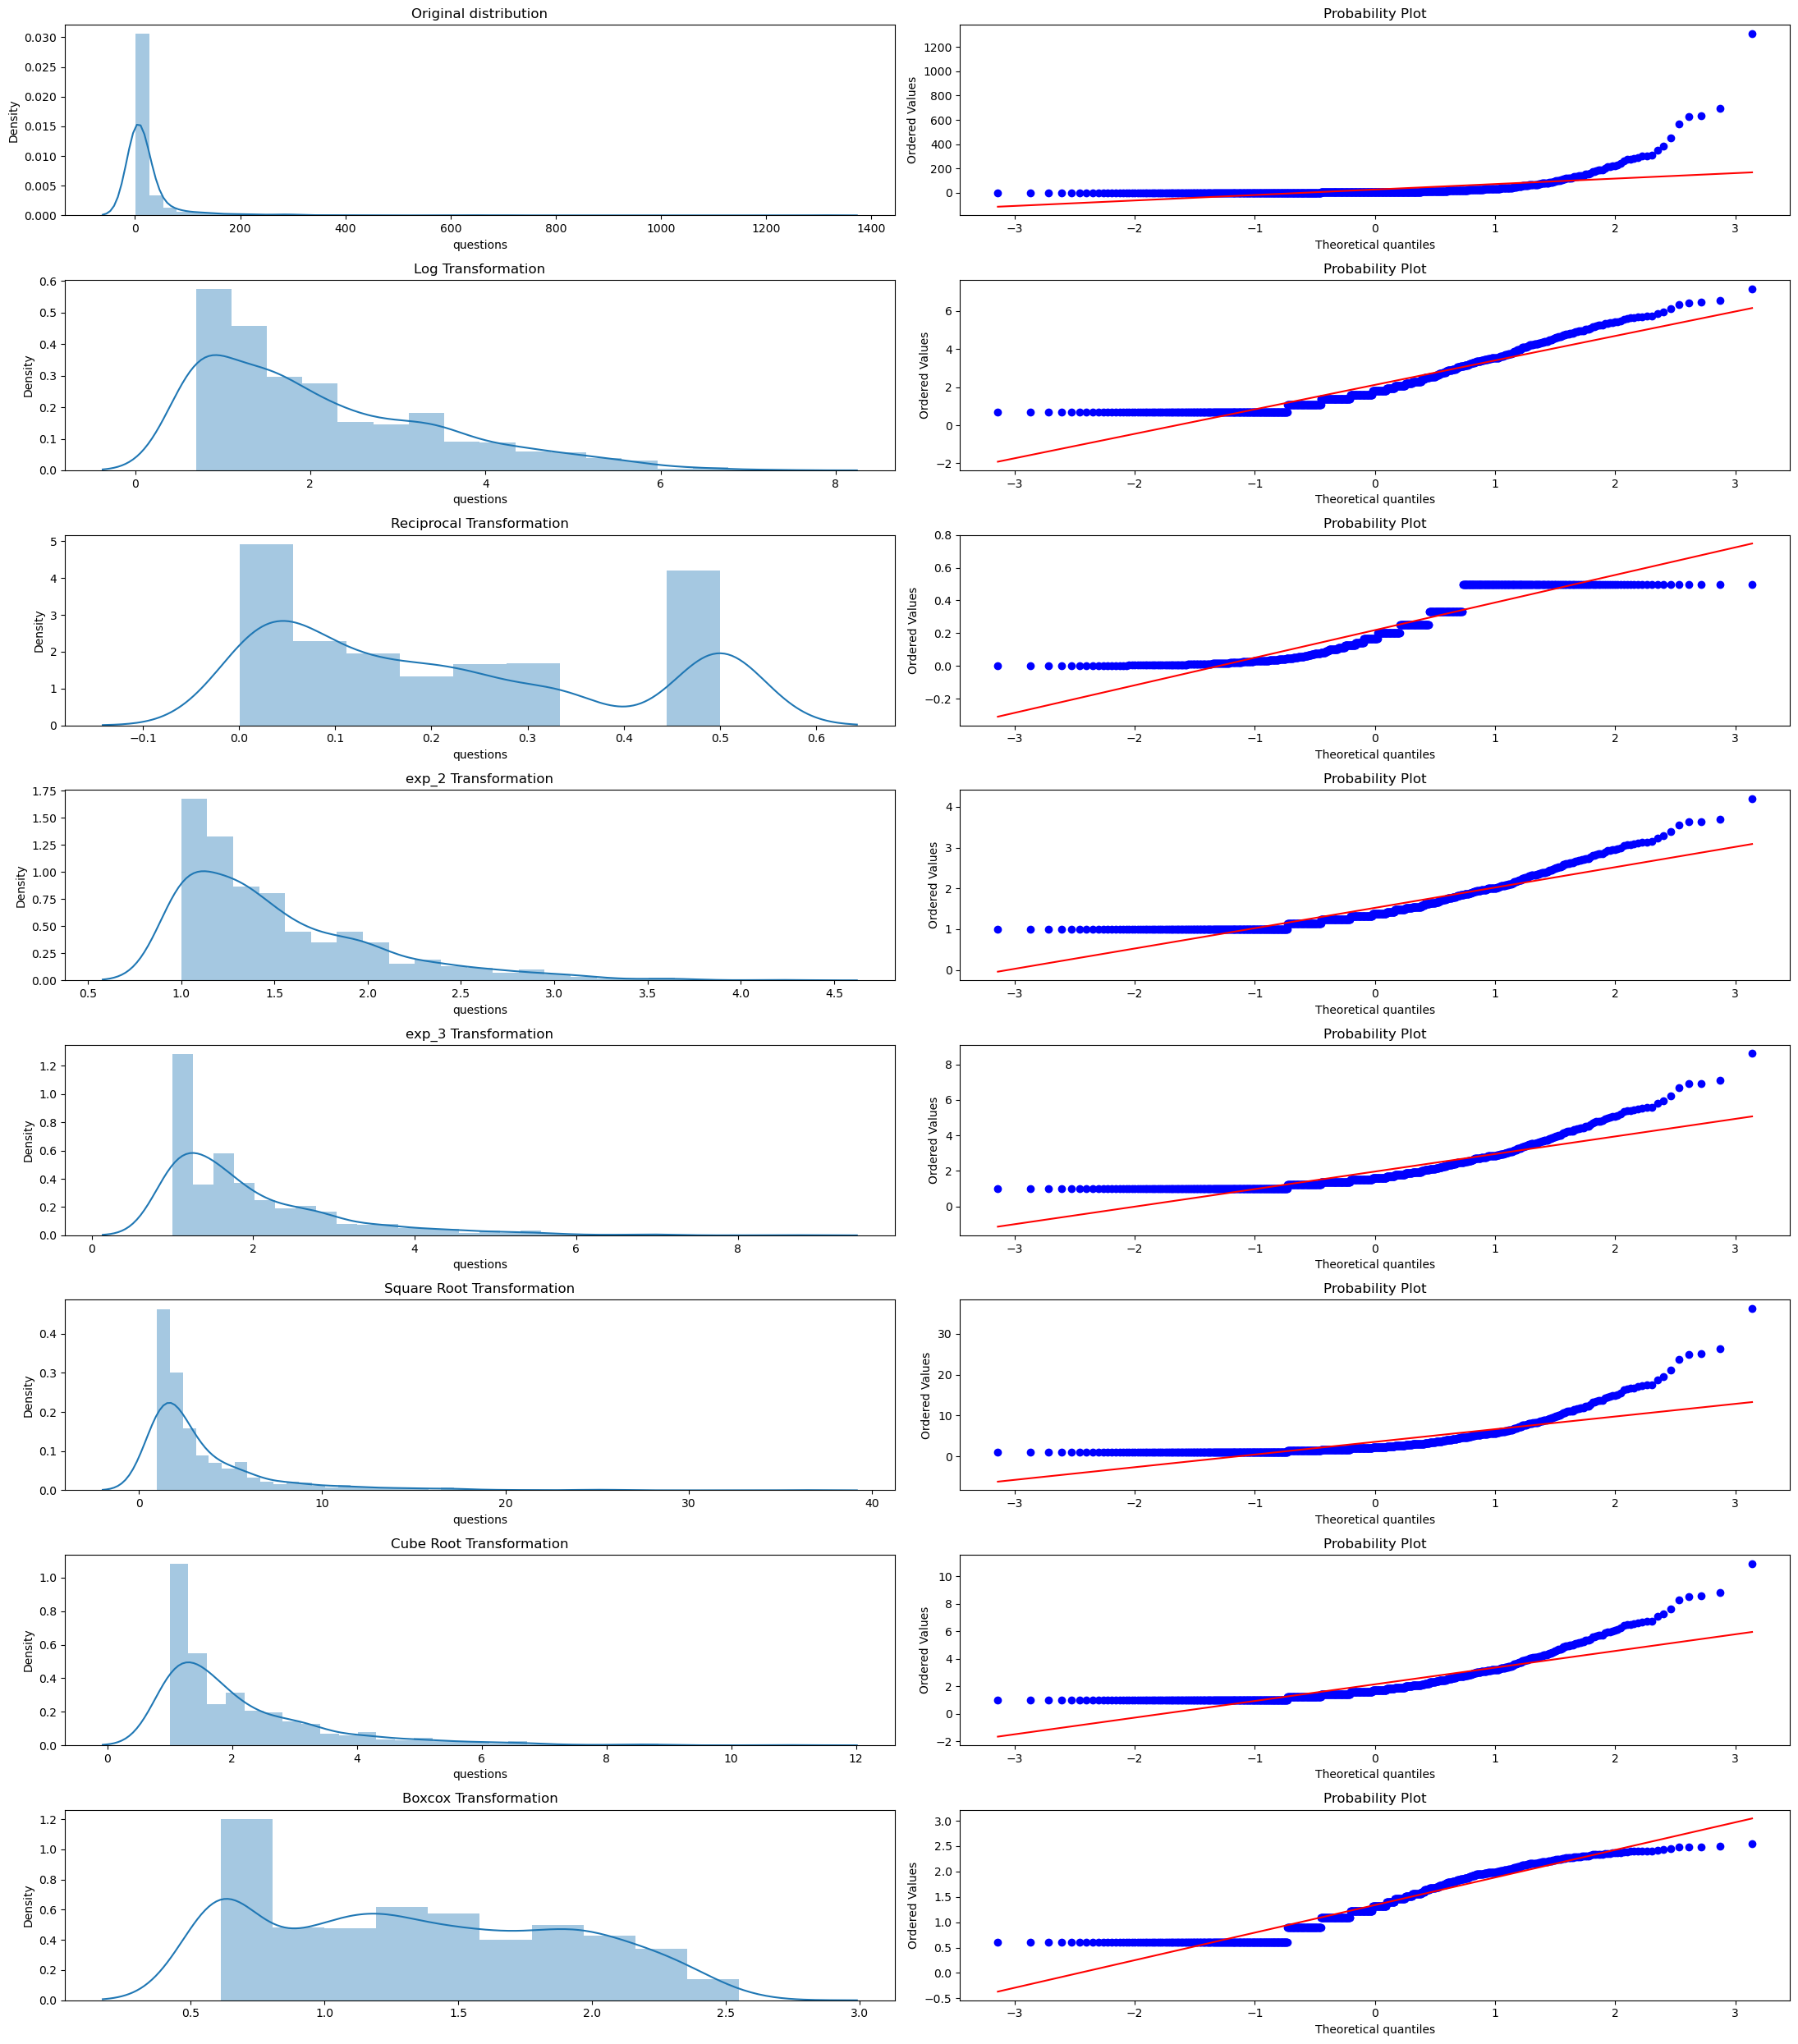

ANSWERS 

       Transformation      Skew
               Actual 11.814233
                  Log  1.362735
           Reciprocal -0.128479
Exponential power 0.2  0.672723
Exponential power 0.3  1.696633
          Square Root  4.499996
            Cube Root  2.102851
               Boxcox  0.428515

 Best Transformation for  answers : 
 Reciprocal = -0.12847915469720242


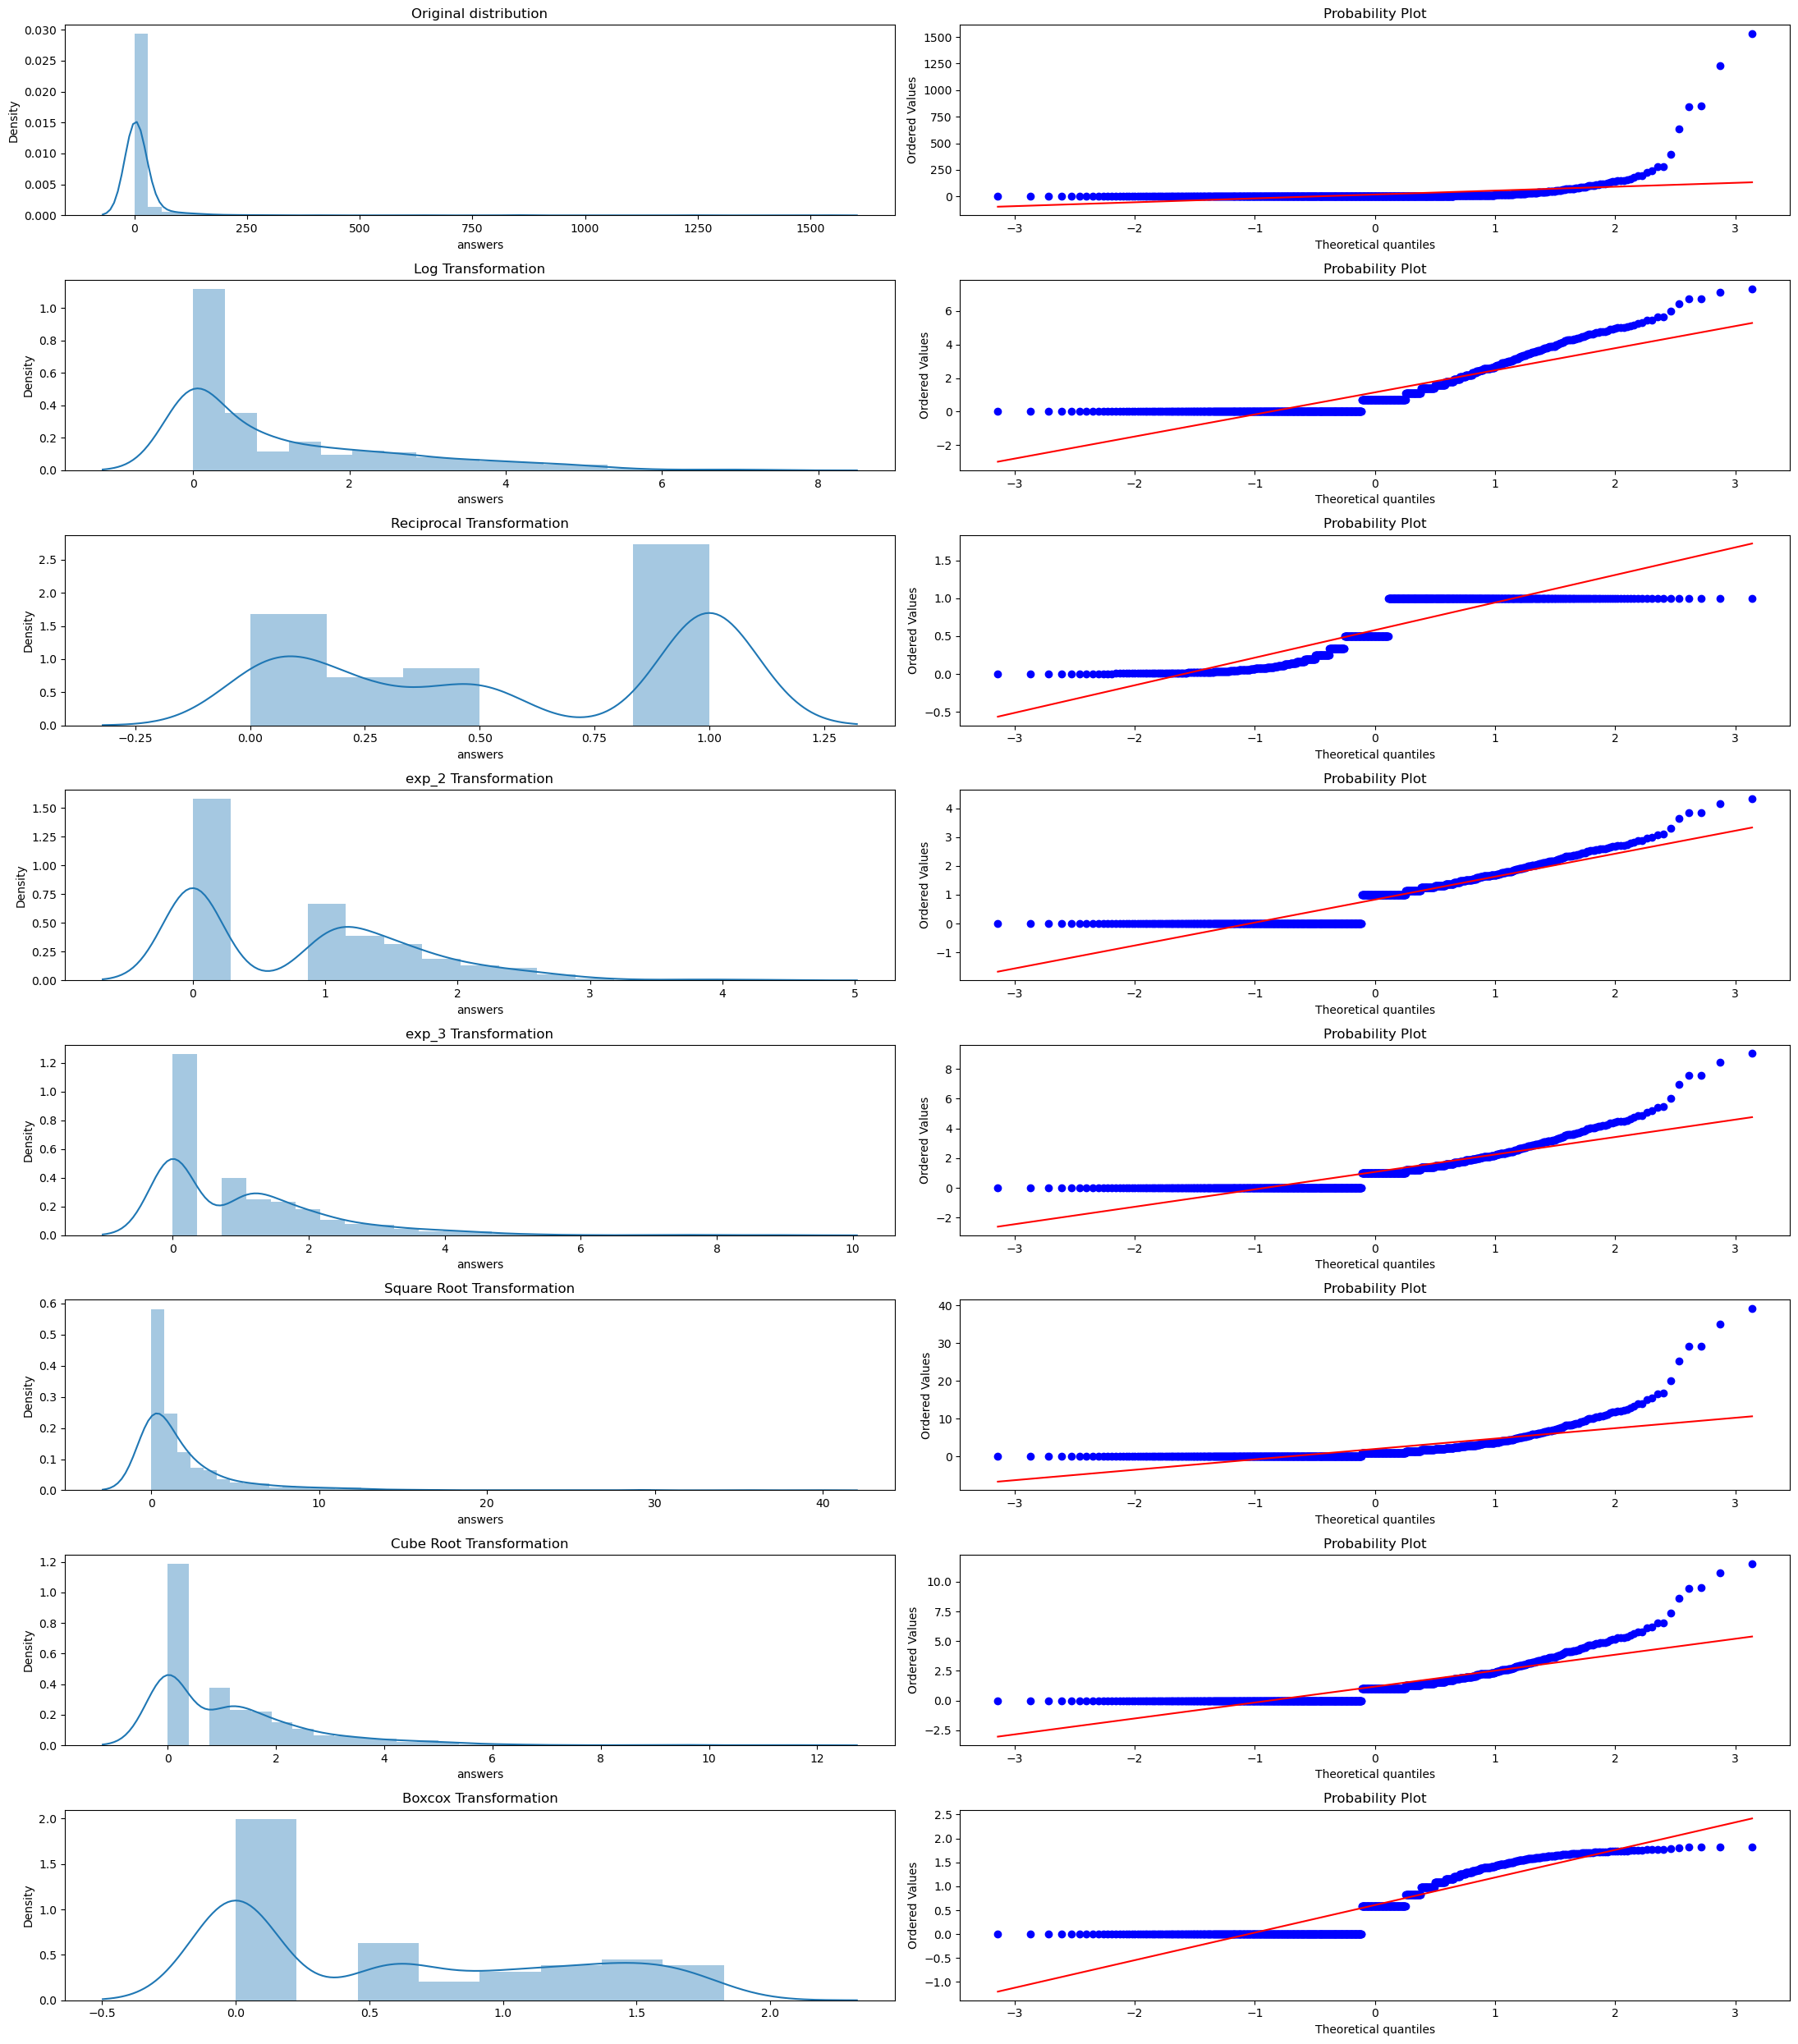

POSTS_EDITED 

       Transformation      Skew
               Actual 20.859901
                  Log  3.633289
           Reciprocal -2.047024
Exponential power 0.2  2.620327
Exponential power 0.3  4.031457
          Square Root  9.002896
            Cube Root  4.684717
               Boxcox  1.813141

 Best Transformation for  posts_edited : 
 Boxcox = 1.8131412449739577


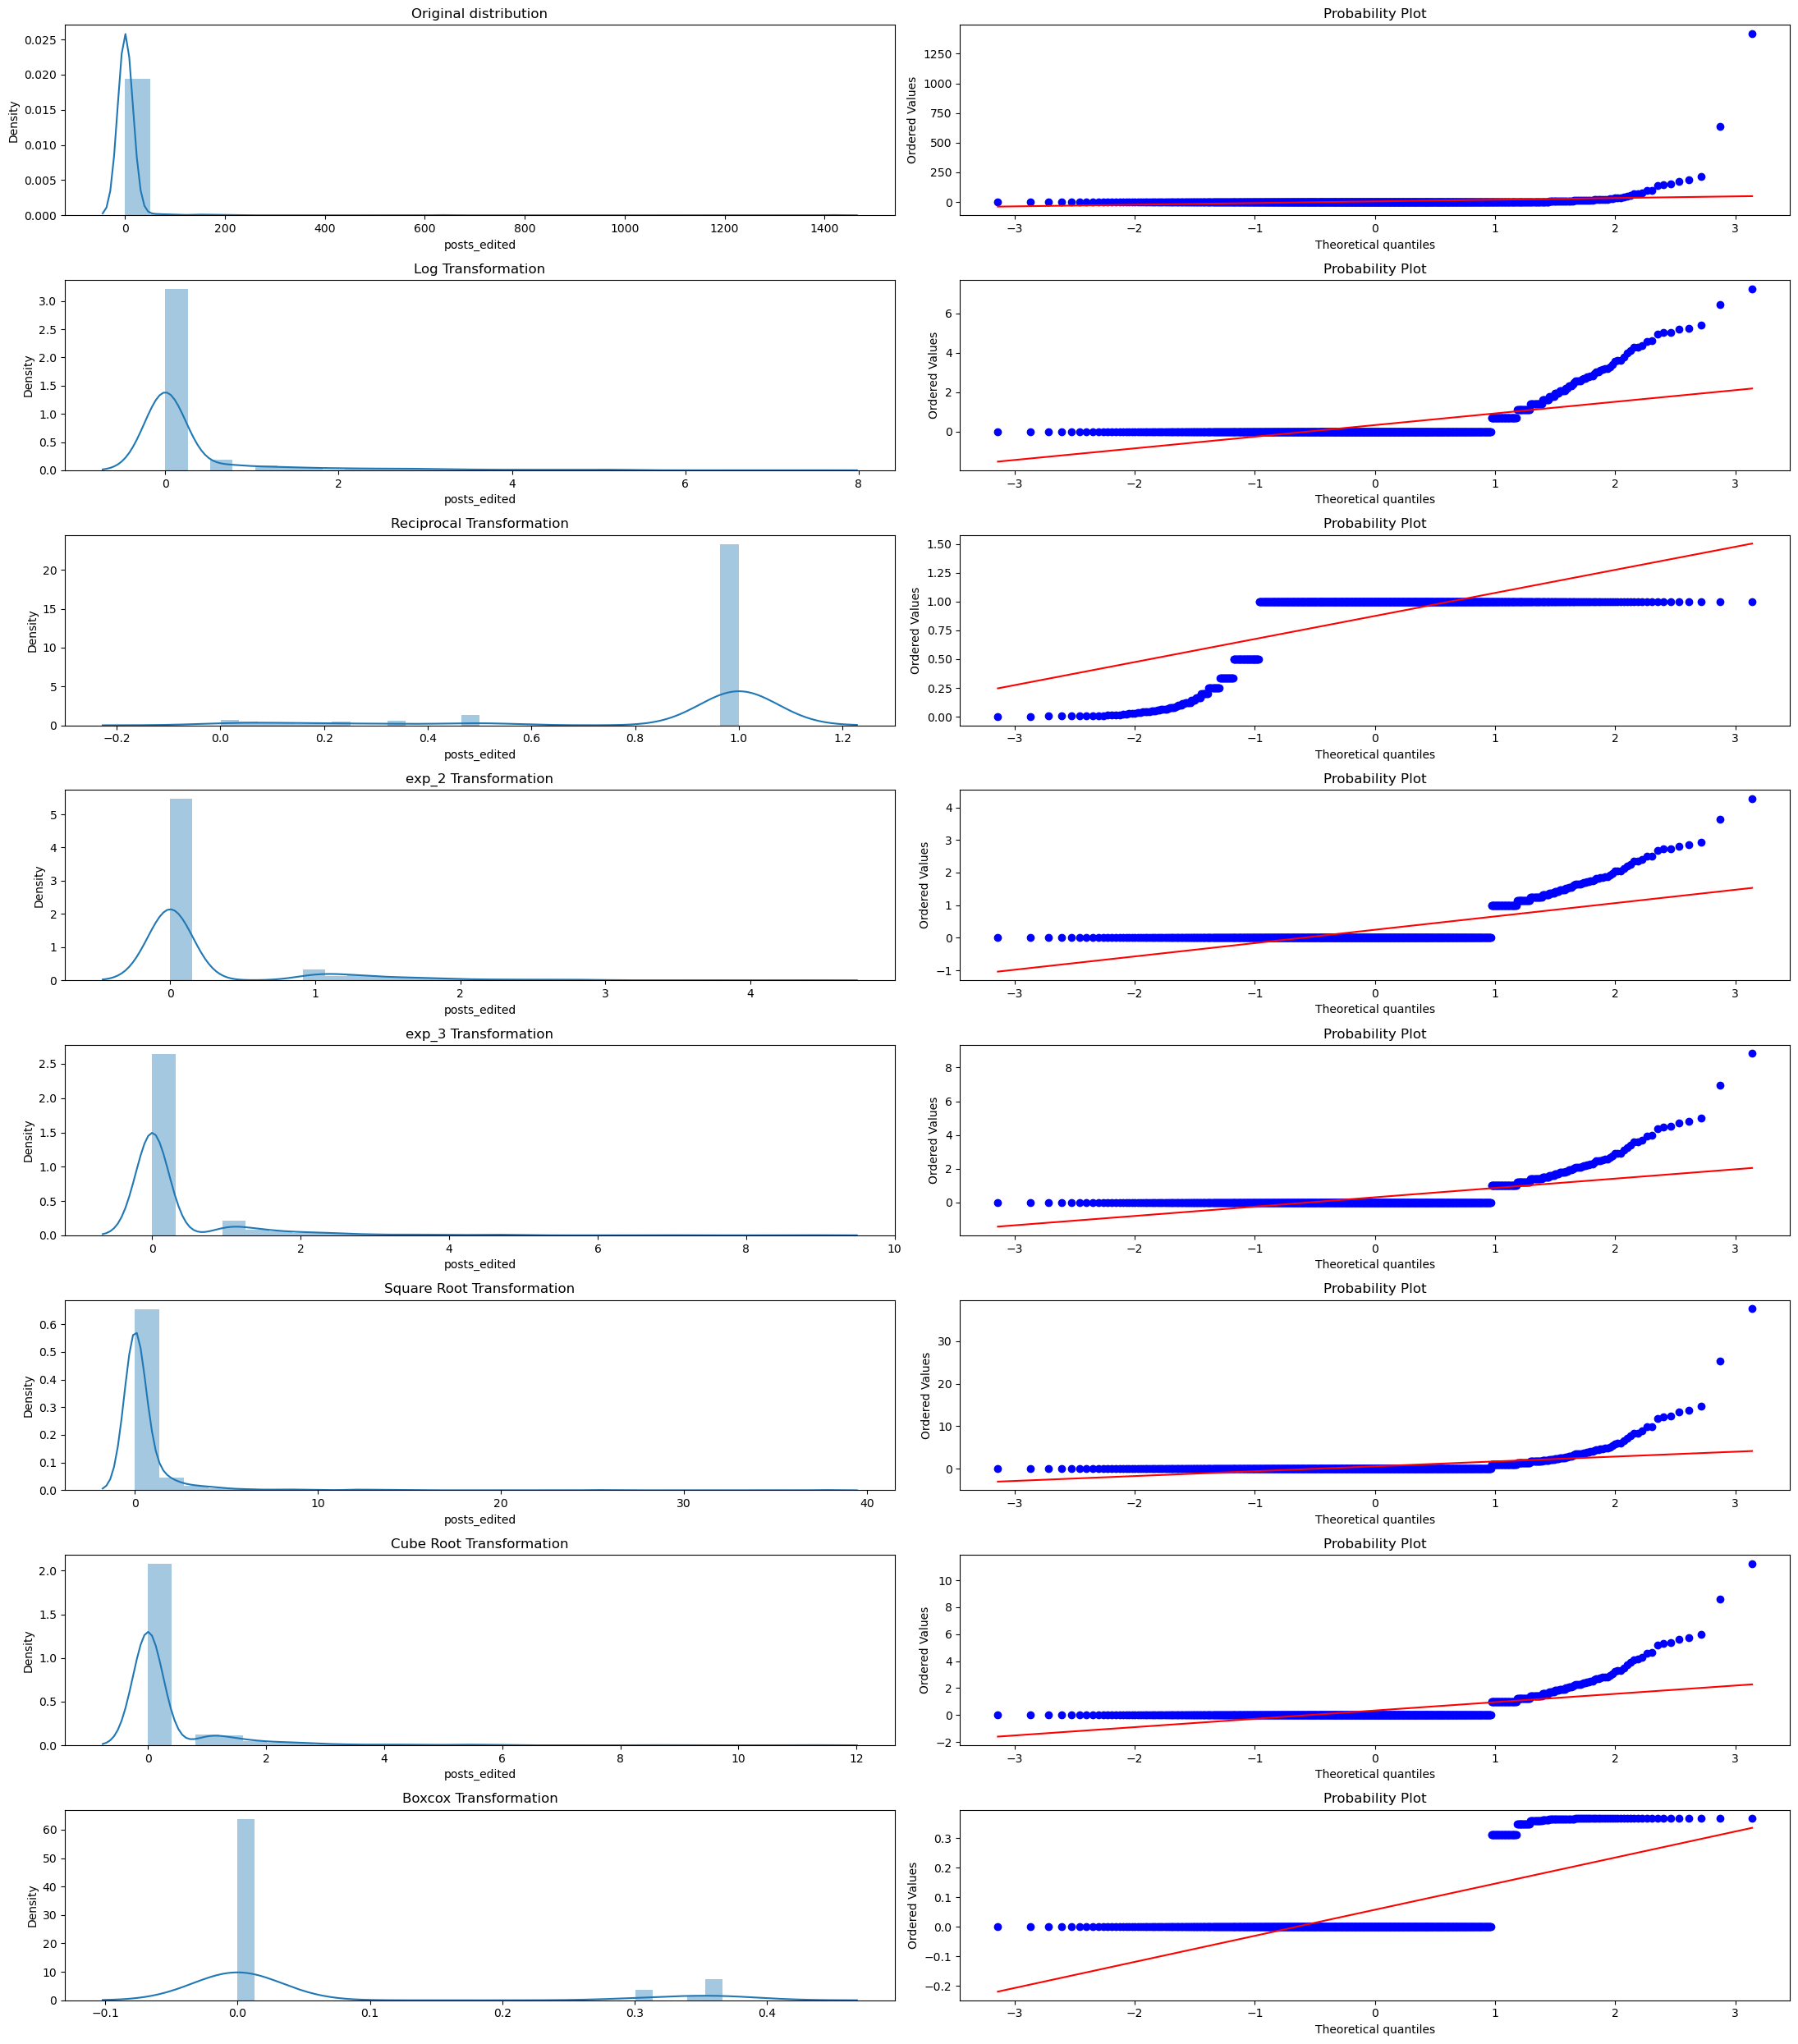

HELPFUL_TAGS 

       Transformation      Skew
               Actual 19.048269
                  Log  4.906796
           Reciprocal -2.328394
Exponential power 0.2  3.390270
Exponential power 0.3  5.696743
          Square Root 10.819576
            Cube Root  6.603232
               Boxcox  2.005740

 Best Transformation for  helpful_tags : 
 Boxcox = 2.0057402070517423


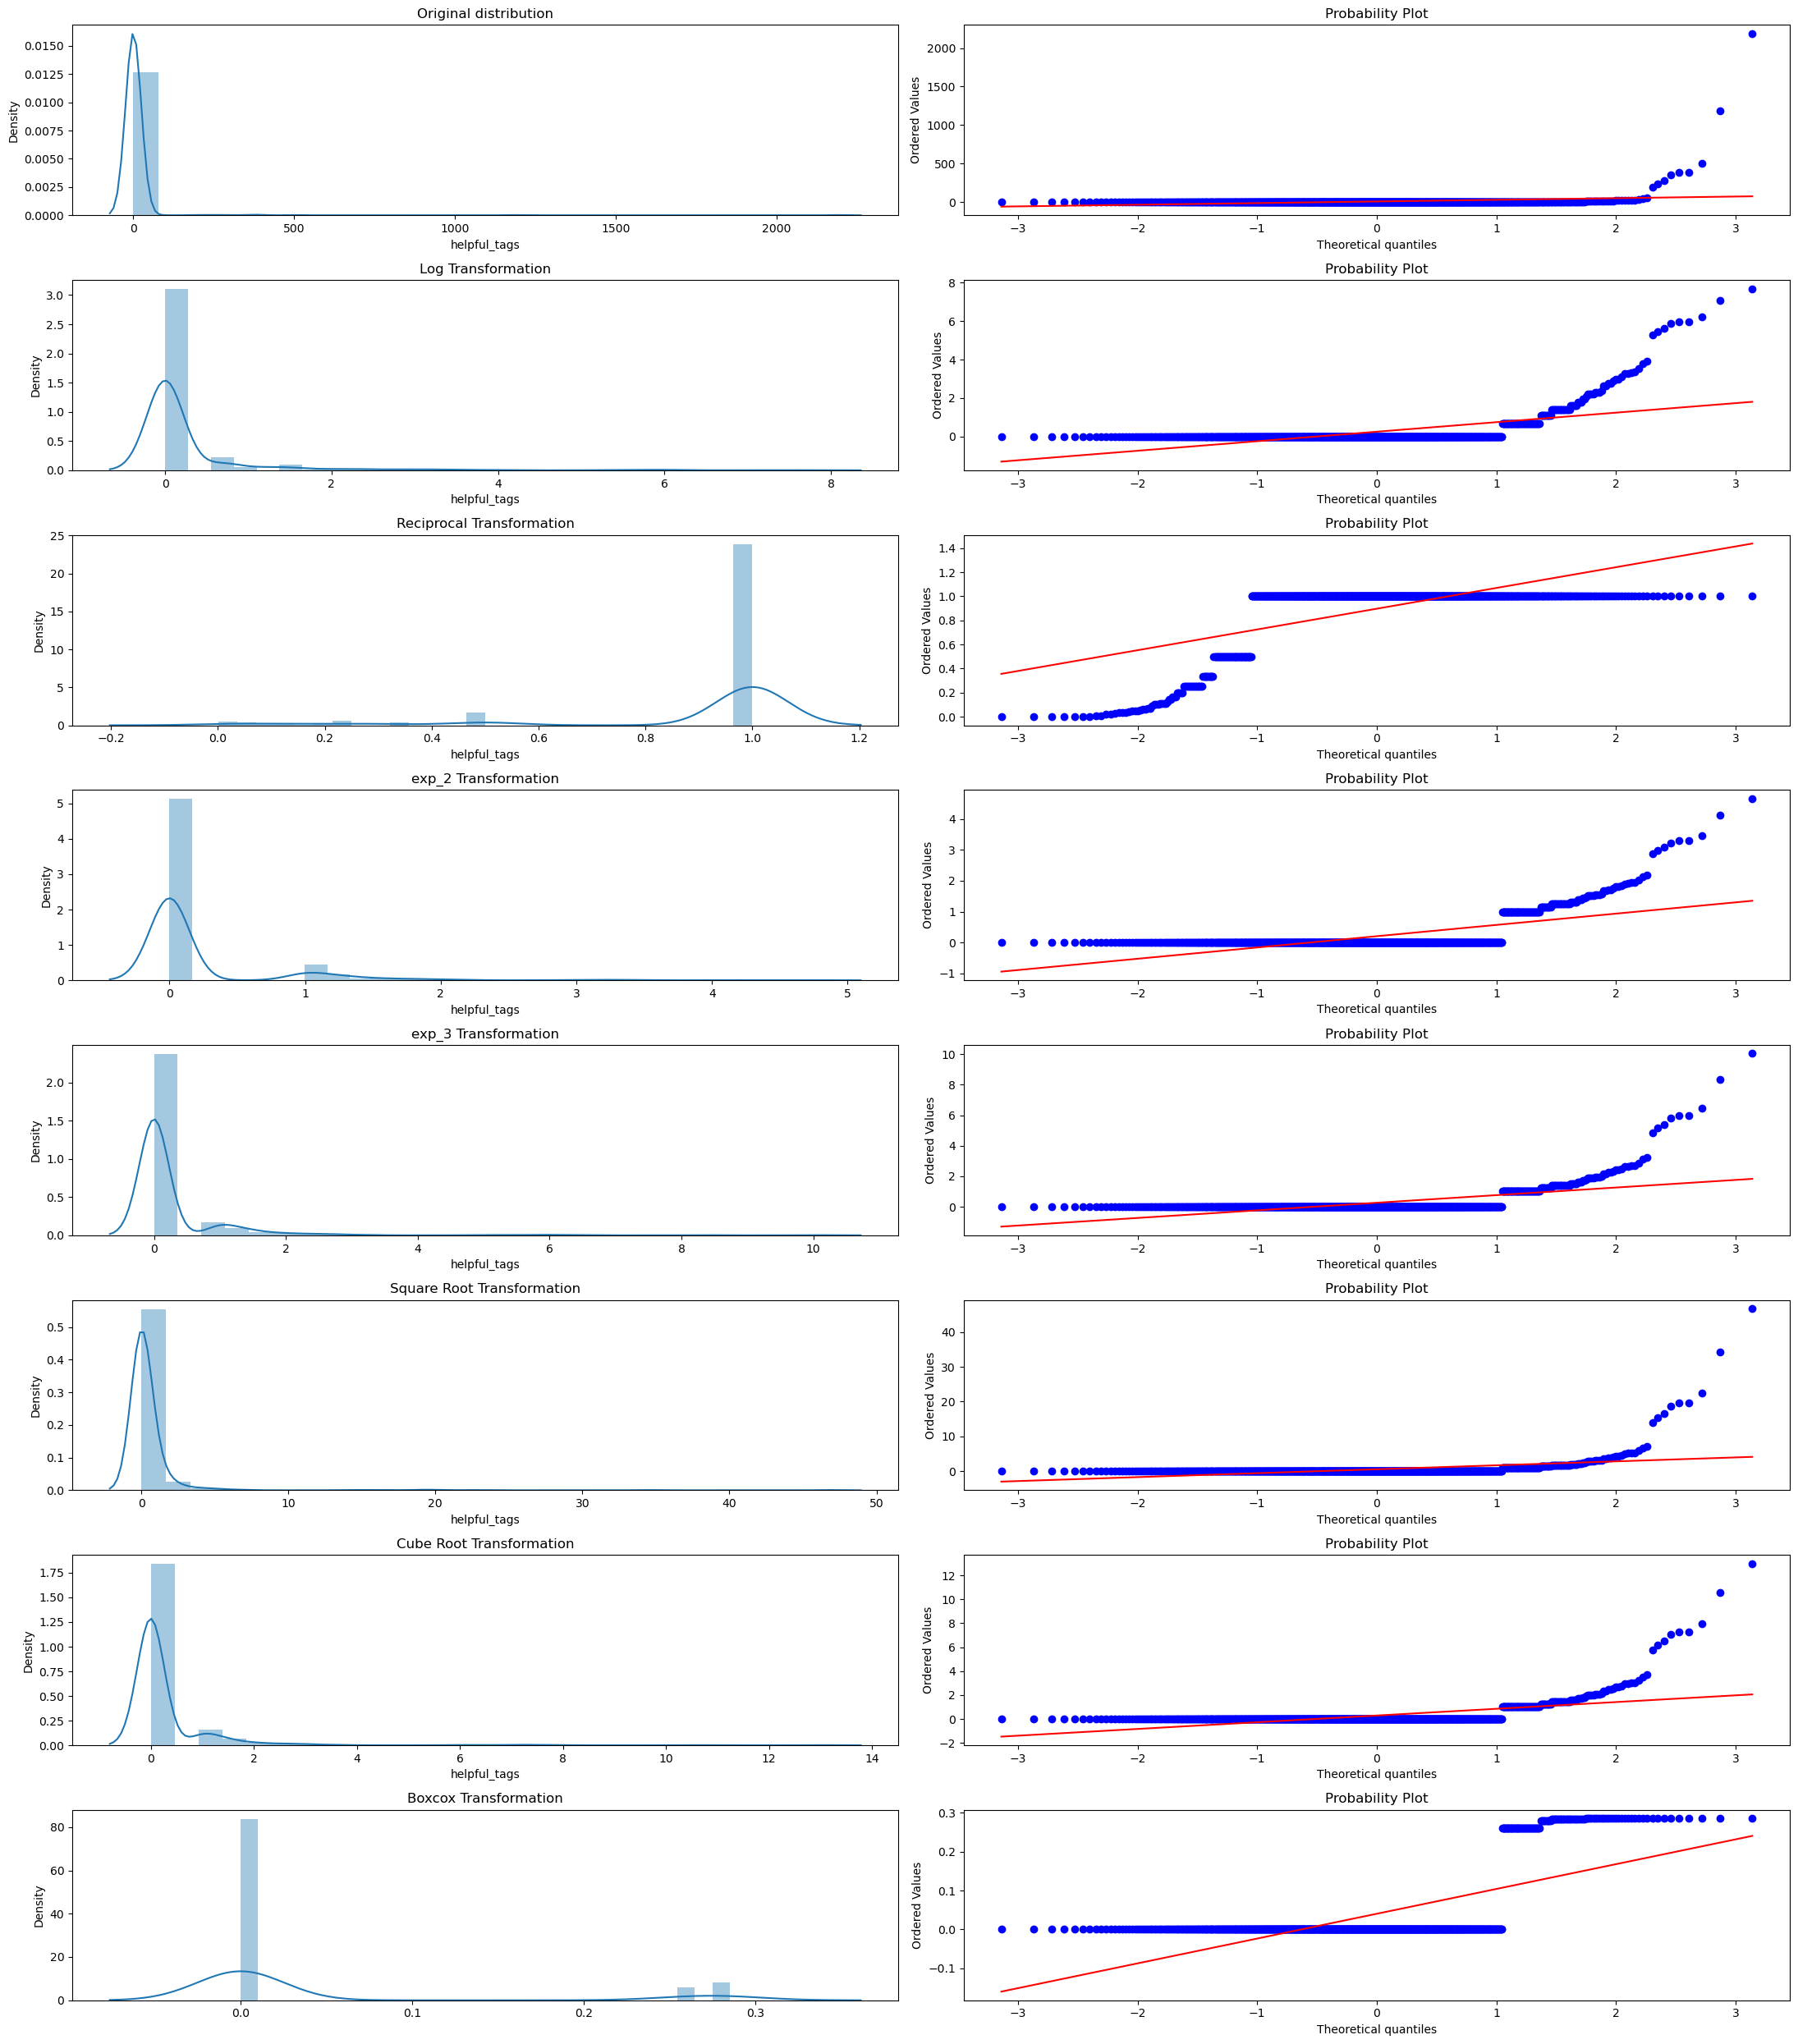

VOTES_CAST 

       Transformation      Skew
               Actual 12.880419
                  Log  0.773081
           Reciprocal  0.181797
Exponential power 0.2  0.743013
Exponential power 0.3  1.551827
          Square Root  3.425594
            Cube Root  1.828033
               Boxcox  0.305081

 Best Transformation for  votes_cast : 
 Reciprocal = 0.1817970842051075


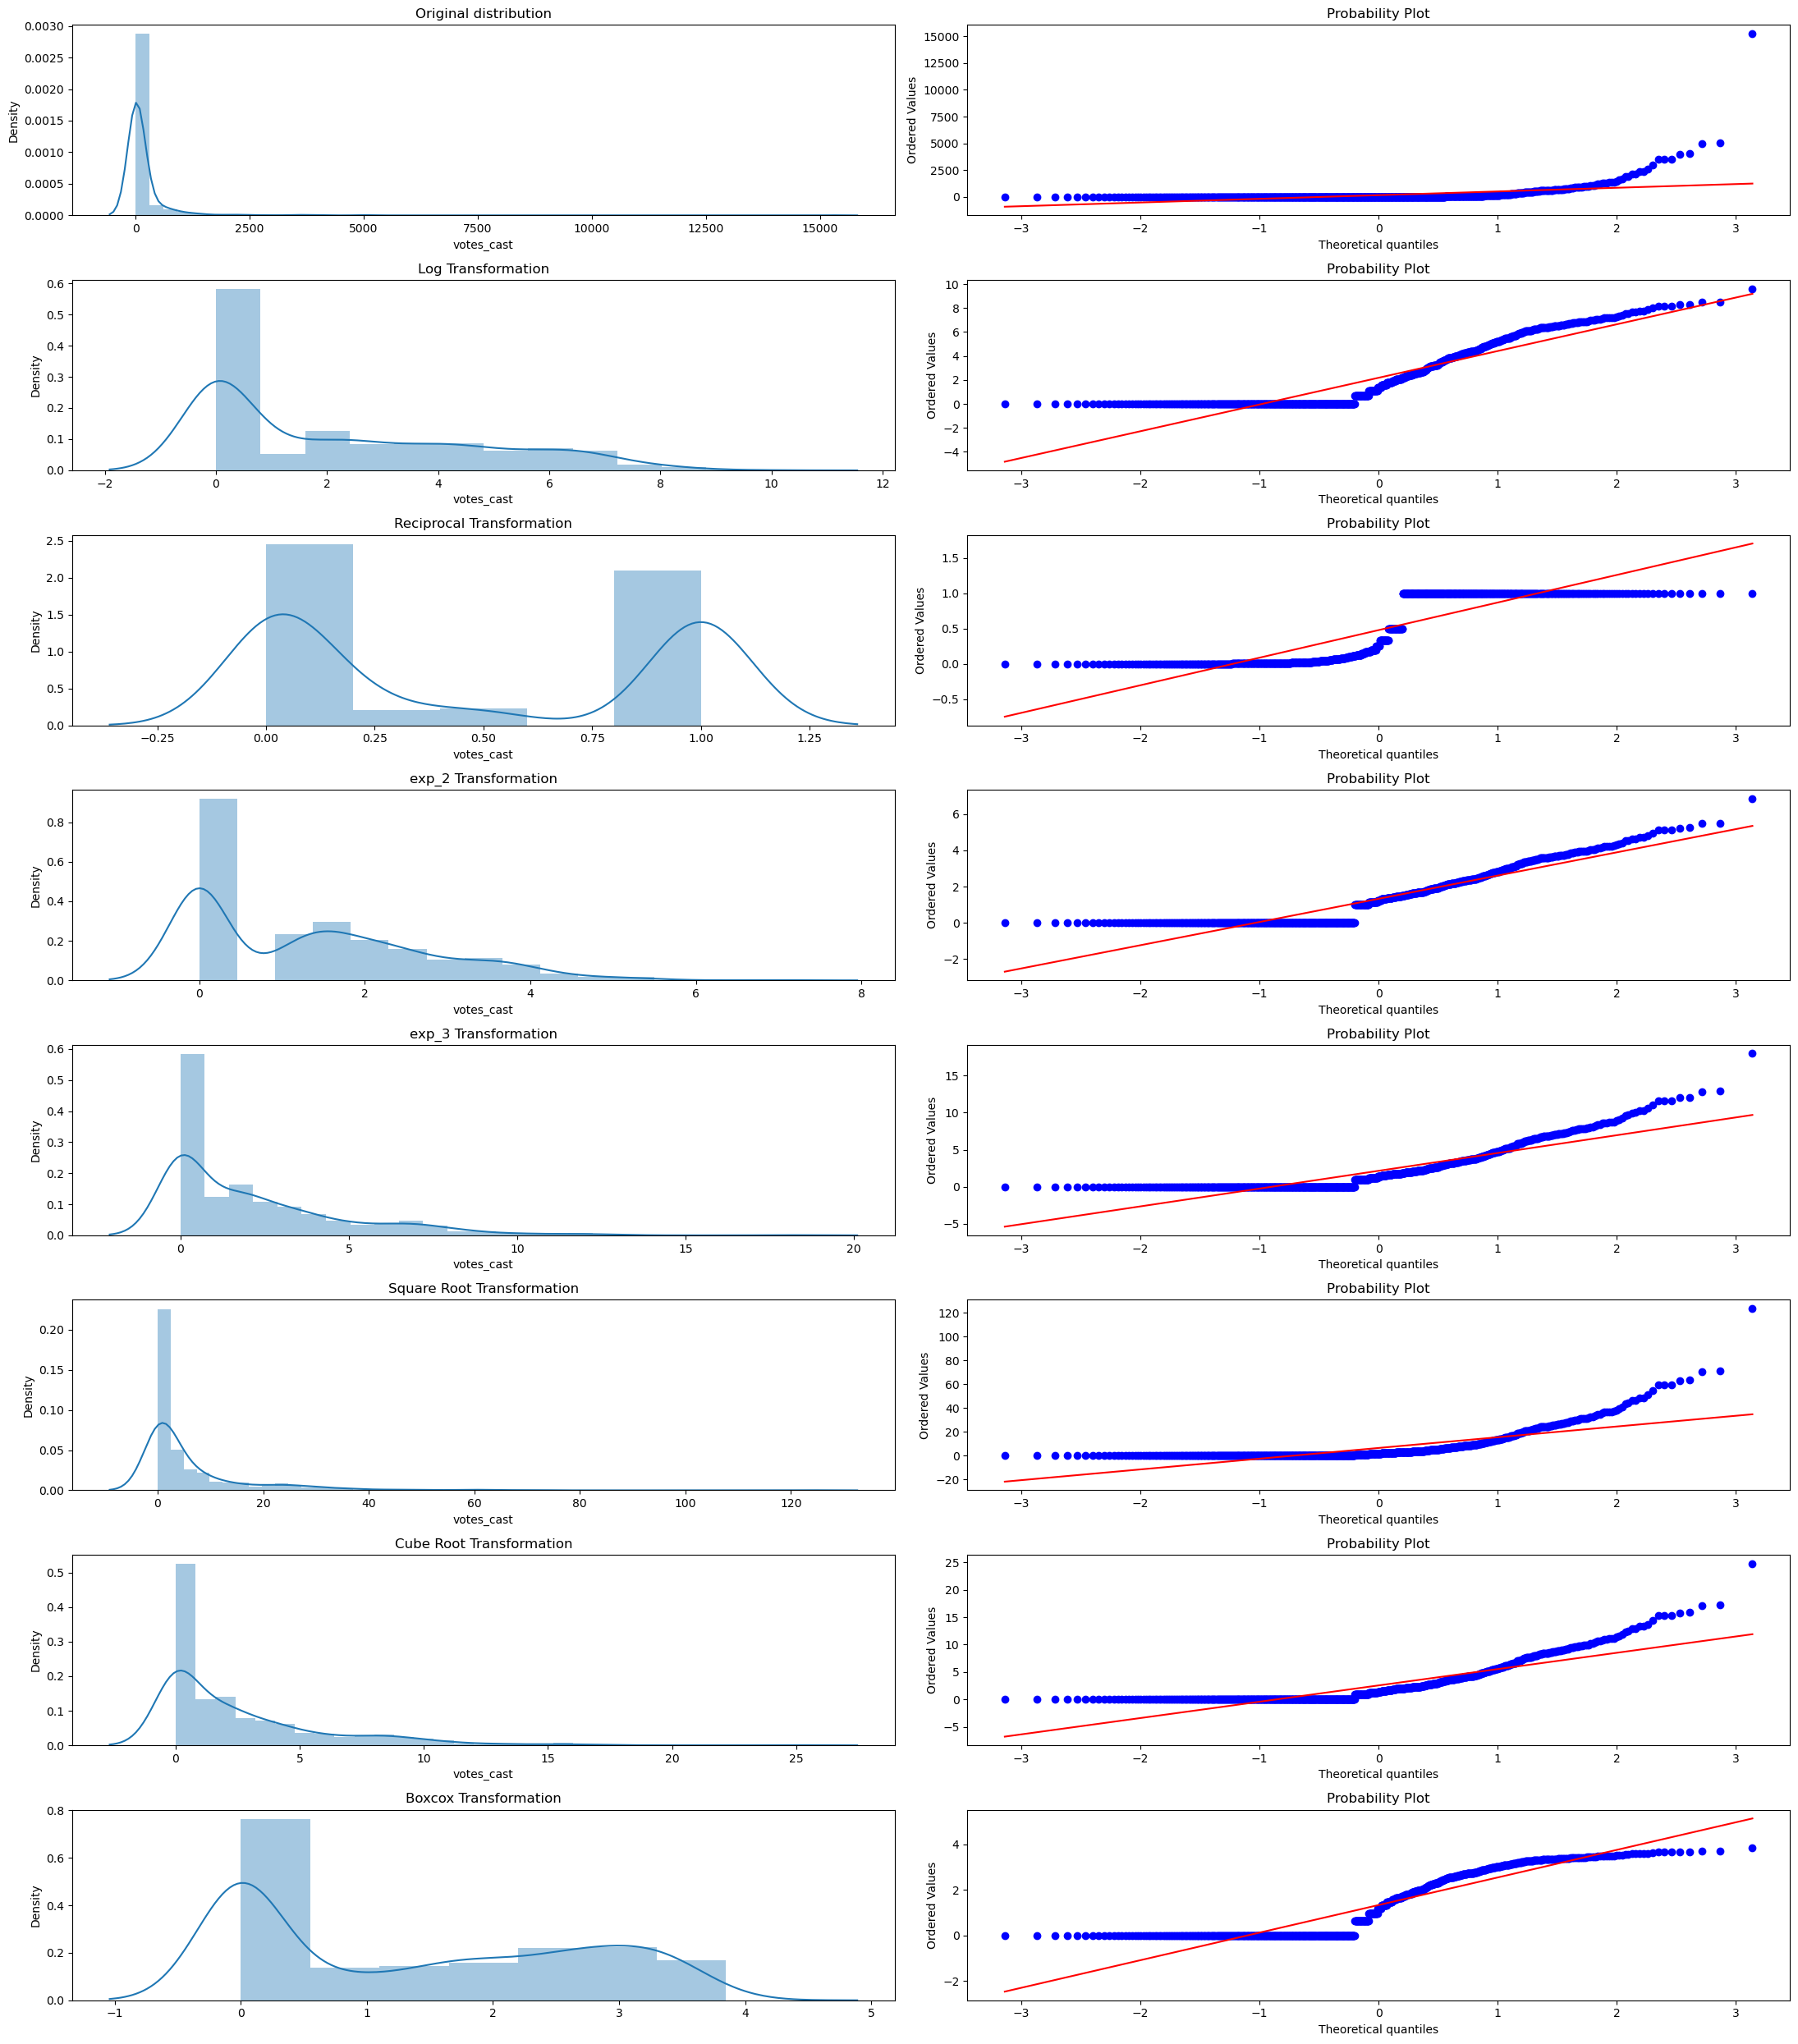

WEIGHTED_BADGE_SCORE 

       Transformation      Skew
               Actual 10.761203
                  Log  0.063200
           Reciprocal  2.649231
Exponential power 0.2 -0.296746
Exponential power 0.3  1.166626
          Square Root  3.689375
            Cube Root  1.595672
               Boxcox -0.001507

 Best Transformation for  weighted_badge_score : 
 Boxcox = -0.0015065668592527178


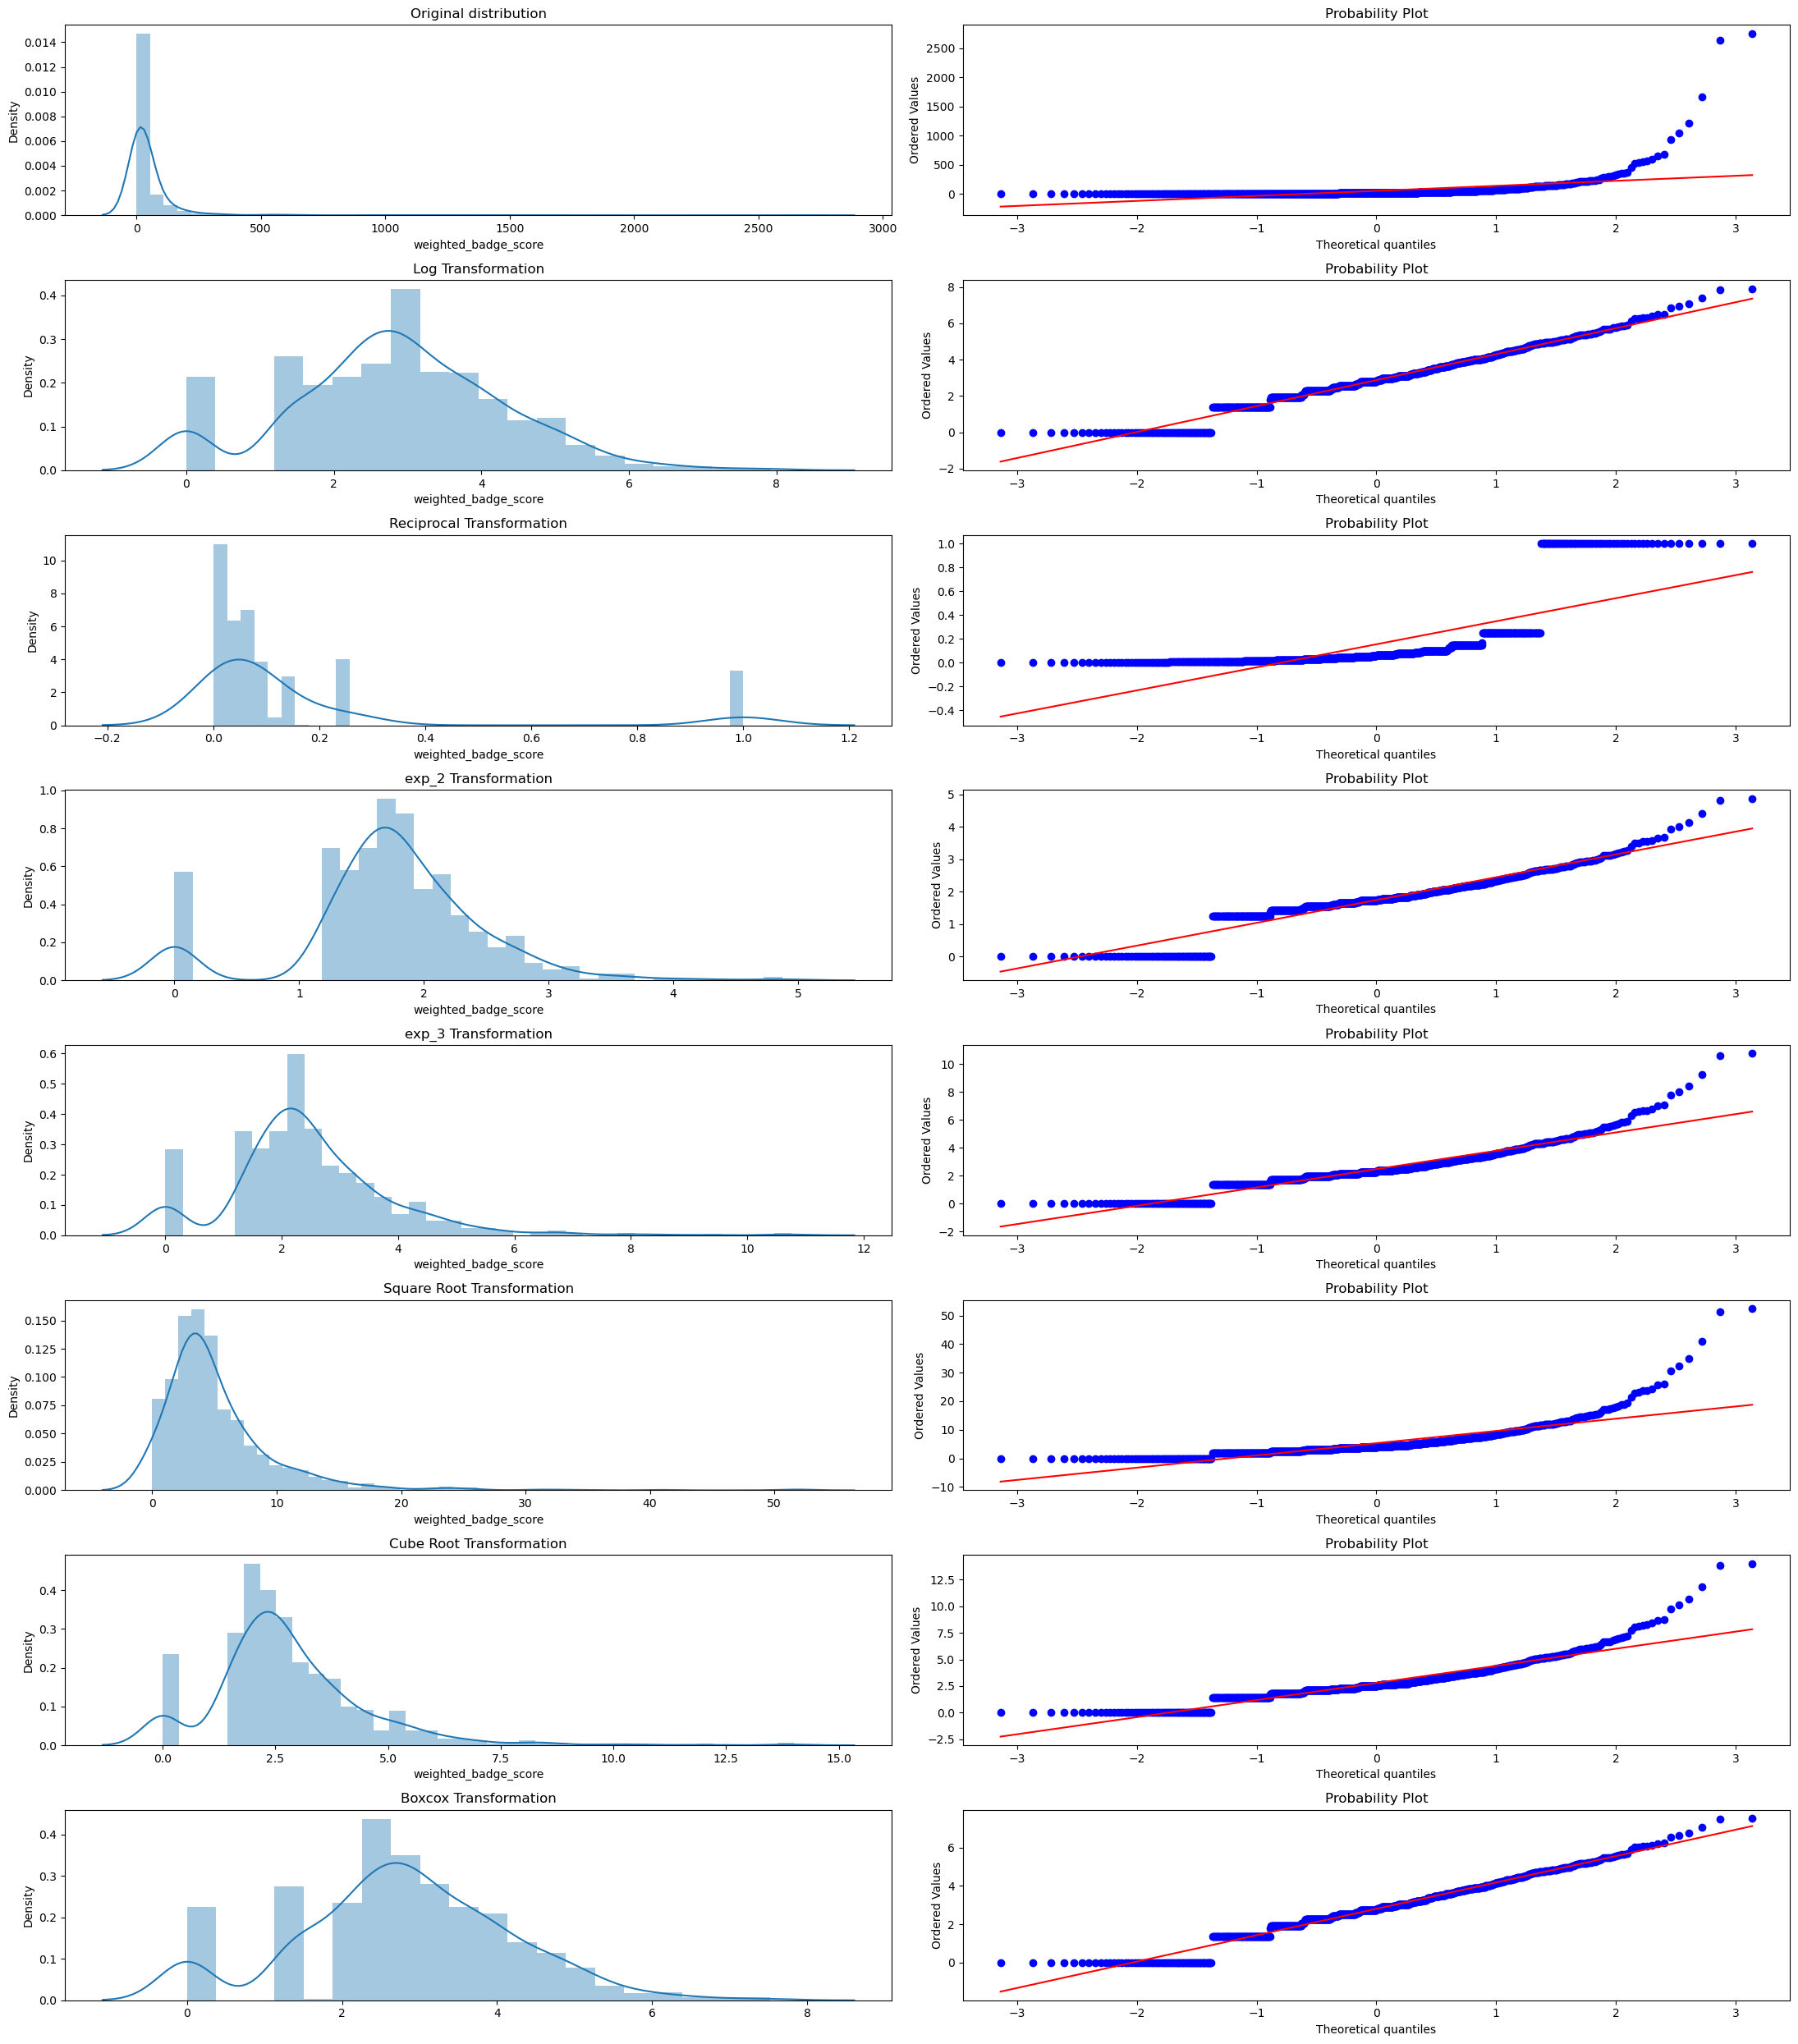

QA_RATIO 

       Transformation      Skew
               Actual 14.053602
                  Log  3.227160
           Reciprocal -1.403751
Exponential power 0.2  0.565060
Exponential power 0.3  1.587640
          Square Root  4.815453
            Cube Root  2.025765
               Boxcox  0.774641

 Best Transformation for  QA_ratio : 
 Exponential power 0.2 = 0.5650598923399888


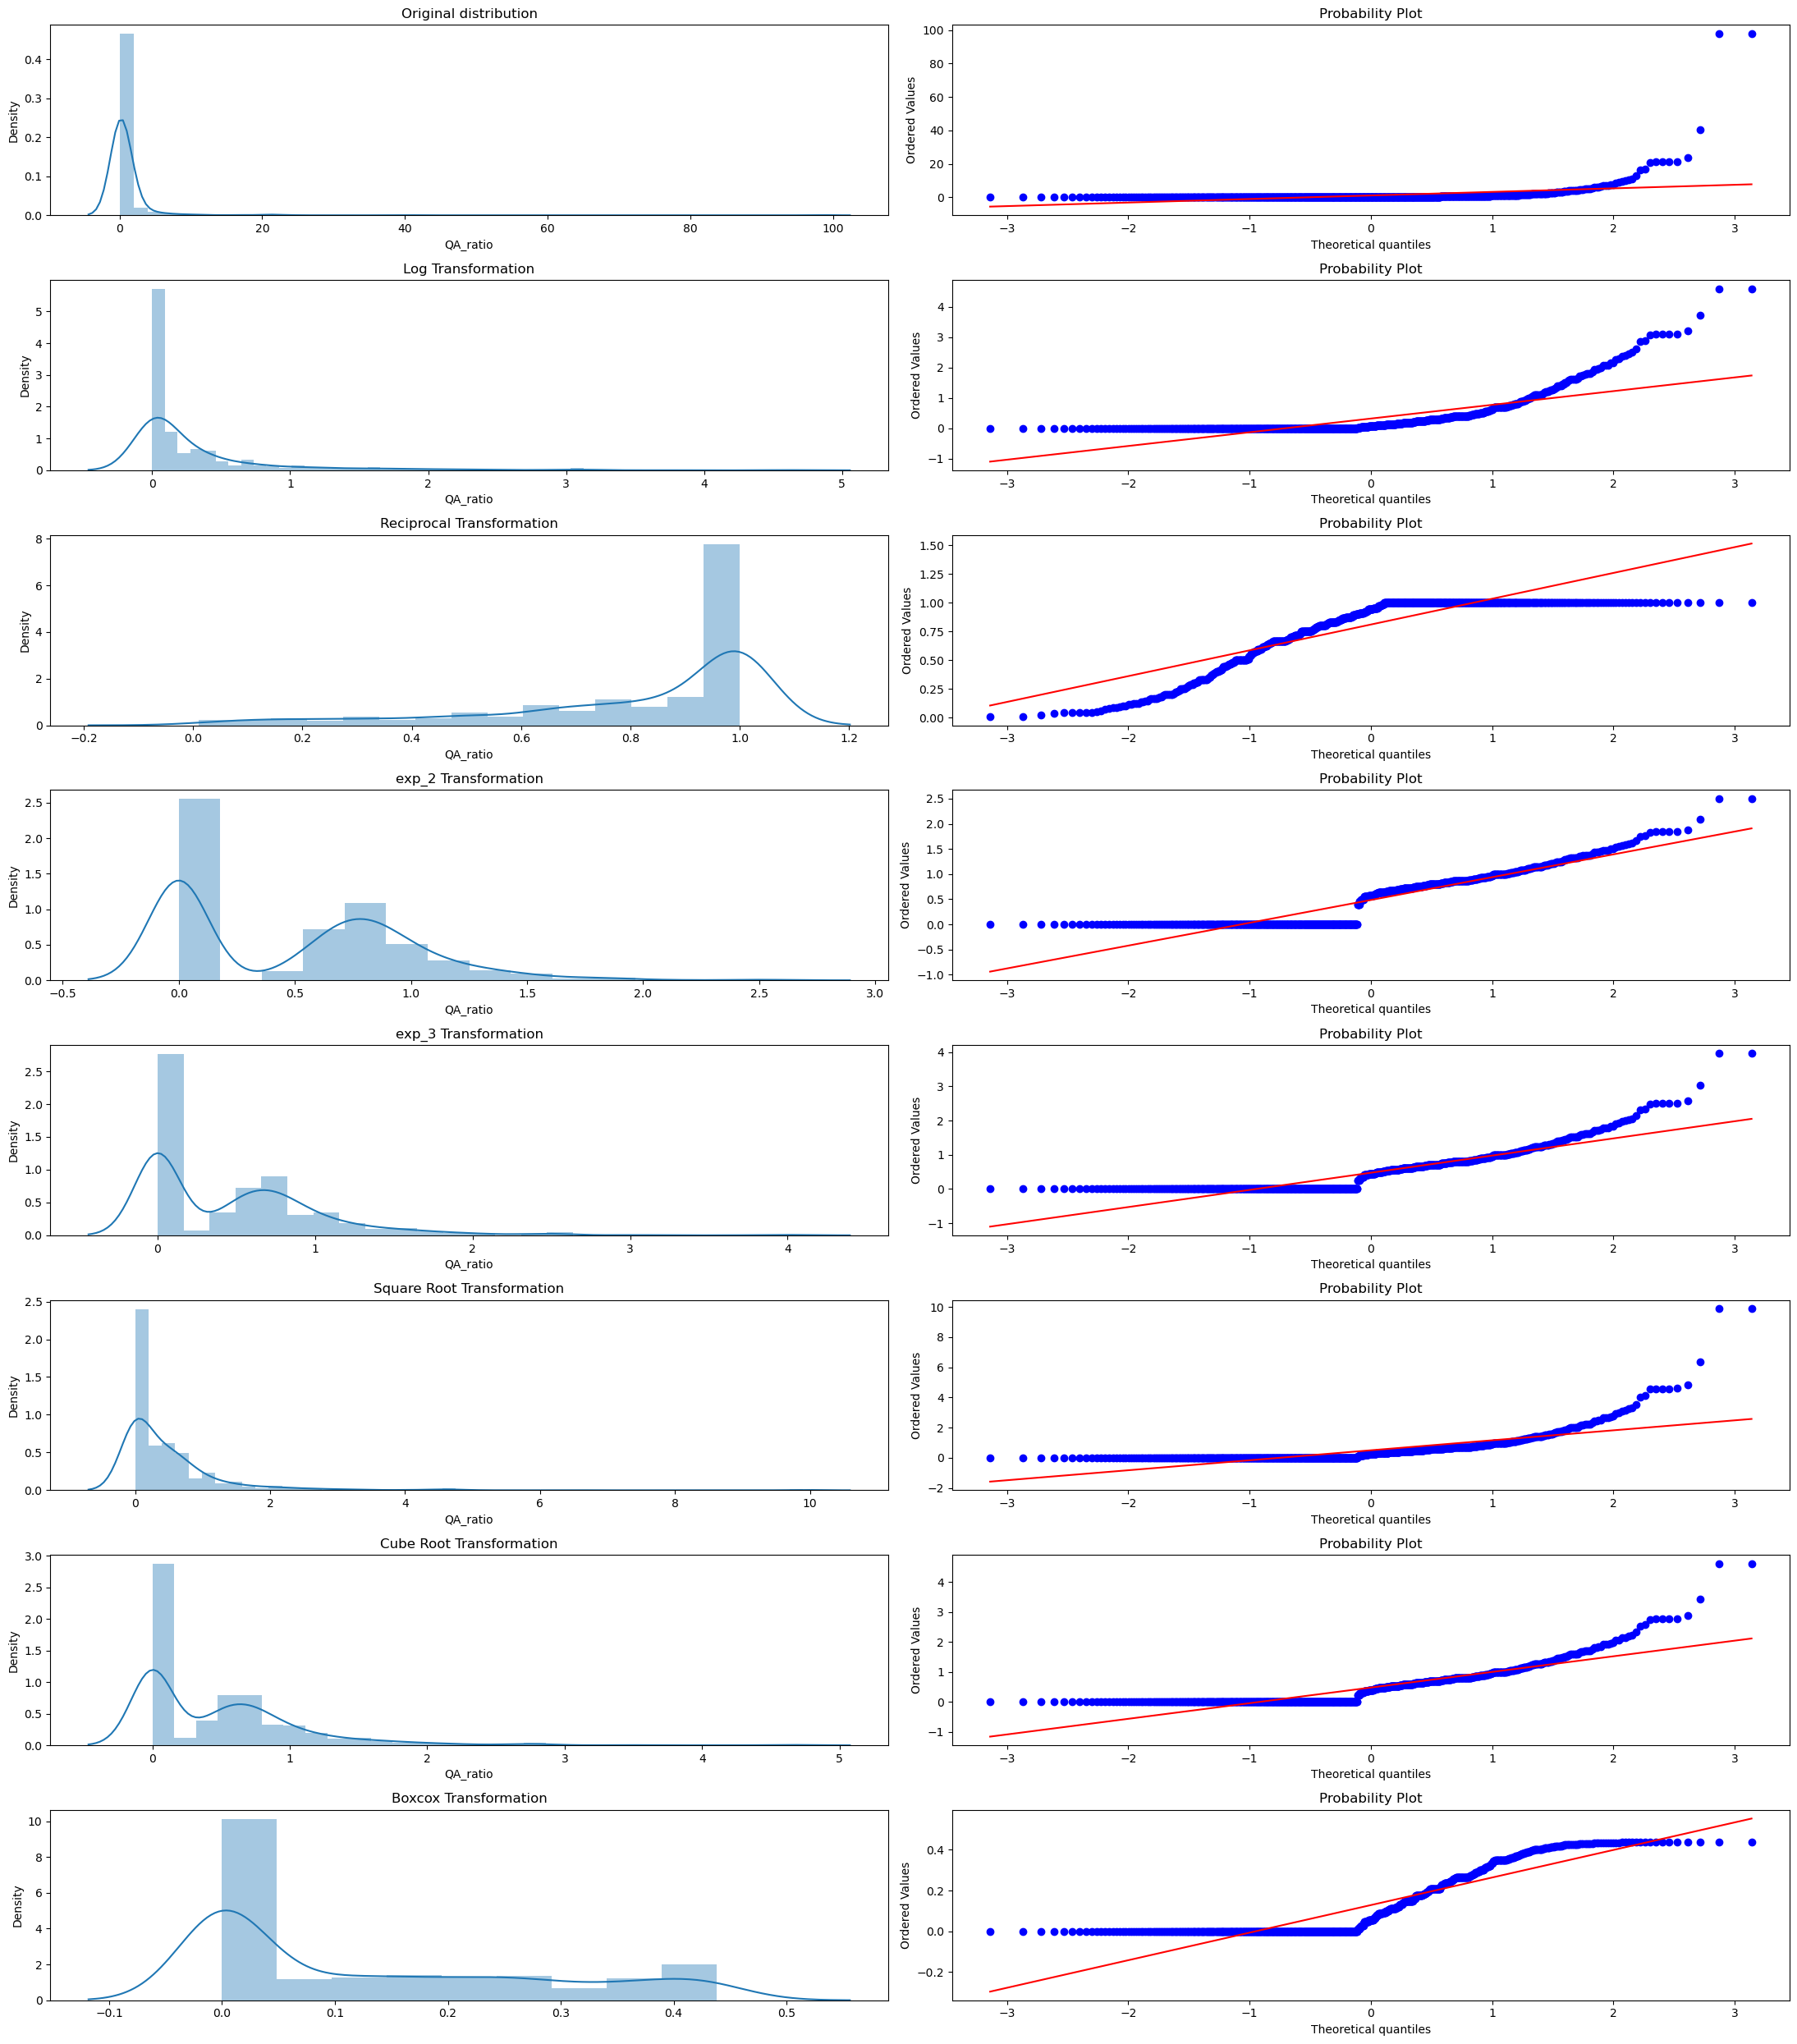

In [17]:
for column in ['reputation', 'reached', 'questions', 'answers',
        'posts_edited', 'helpful_tags', 'votes_cast',
        'weighted_badge_score', 'QA_ratio']:
    
    print('\033[1m'+column.upper()+'\033[0m','\n')
    plt.figure(figsize=(22,25))
    
    raw_skewness = df_train[column].skew()
    
    plt.subplot(8,2,1)
    sns.distplot(df_train[column])
    plt.title('Original distribution')
    
    plt.subplot(8,2,2)
    st.probplot(df_train[column],dist='norm',plot=plt)
    
    
    #log transformation
    log_transform = np.log(df_train[column]+1)
    log_skew=log_transform.skew()

    plt.subplot(8,2,3)
    sns.distplot(log_transform)
    plt.title('Log Transformation')

    plt.subplot(8,2,4)
    st.probplot(log_transform,dist='norm',plot=plt)
    
    #Reciprocal Transformation  
    recip_transform = 1/(df_train[column]+1)
    recip_skew=recip_transform.skew()

    plt.subplot(8,2,5)
    sns.distplot(recip_transform)
    plt.title('Reciprocal Transformation')

    plt.subplot(8,2,6)
    st.probplot(recip_transform,dist='norm',plot=plt)
    
    #Exponential Transformation
    
    exp_2 = df_train[column]**0.2
    exp_2_skew=exp_2.skew()
    
    plt.subplot(8,2,7)
    sns.distplot(exp_2)
    plt.title('exp_2 Transformation')
    
    plt.subplot(8,2,8)
    st.probplot(exp_2,dist='norm',plot=plt)
    
    exp_3 = df_train[column]**0.3
    exp_3_skew=exp_3.skew()
    
    plt.subplot(8,2,9)
    sns.distplot(exp_3)
    plt.title('exp_3 Transformation')
    
    plt.subplot(8,2,10)
    st.probplot(exp_3,dist='norm',plot=plt)
    
    #Square Root Transformation
    
    sqrt_transform = df_train[column]**(1/2)
    sqrt_transform_skew=sqrt_transform.skew()
    
    plt.subplot(8,2,11)
    sns.distplot(sqrt_transform)
    plt.title('Square Root Transformation')
    
    plt.subplot(8,2,12)
    st.probplot(sqrt_transform,dist='norm',plot=plt)
    
    #Cube Root Transformation
    
    cube_transform = df_train[column]**(1/3)
    cube_transform_skew=cube_transform.skew()
    
    plt.subplot(8,2,13)
    sns.distplot(cube_transform)
    plt.title('Cube Root Transformation')
    
    plt.subplot(8,2,14)
    st.probplot(cube_transform,dist='norm',plot=plt)
    
    #Boxcox Transformation
    box,param = st.boxcox(df_train[column]+1)
    boxcox_skew=pd.DataFrame(box).skew()

    plt.subplot(8,2,15)
    plt.tight_layout()
    sns.distplot(pd.DataFrame(box))
    plt.title('Boxcox Transformation')

    plt.subplot(8,2,16)
    st.probplot(box,dist='norm',plot=plt)
    
    trans_result= {'Actual':raw_skewness, 'Log':log_skew,'Reciprocal':recip_skew,'Exponential power 0.2':exp_2_skew,
                       'Exponential power 0.3':exp_3_skew,'Square Root':sqrt_transform_skew,
                       'Cube Root':cube_transform_skew,'Boxcox':boxcox_skew[0]}
    print(pd.DataFrame(trans_result.items(), columns=['Transformation', 'Skew']).to_string(index=False))
    
    lst=list(trans_result.values())
    idx = min((abs(x), x) for x in lst)[1]
    for i in trans_result:
        if (trans_result[i]==idx):
            print('\n','Best Transformation for ',column,':','\n',i,'=',trans_result[i])
    plt.tight_layout() 
    
    plt.show()

In [18]:
df_train['reputation_st'],rep = st.boxcox(df_train['reputation']+1)
df_train['reached_st'],reach = st.boxcox(df_train['reached']+1)
df_train['questions_st'],ques = st.boxcox(df_train['questions']+1)
df_train['answers_st'] = 1/(df_train['answers']+1)
df_train['posts_edited_st'],post = st.boxcox(df_train['posts_edited']+1)
df_train['helpful_tags_st'],help = st.boxcox(df_train['helpful_tags']+1)
df_train['votes_cast_st'] = 1/(df_train['votes_cast']+1)
df_train['weighted_badge_score_st'],badge = st.boxcox(df_train['weighted_badge_score']+1)
df_train['QA_ratio_st'] = df_train['QA_ratio']**0.2

## Scaling with Robust Scaler

In [19]:
st_columns = [i for i in df_train.columns if i.endswith('_st')]
scaler = RobustScaler()
df_train[st_columns] = scaler.fit_transform(df_train[st_columns])
scaled2 = scaler.fit_transform(df_train[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_train.index)
df_train = pd.concat([df_train, df_scaled2], axis=1)

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [21]:
st_columns1 = [i for i in df_train.columns if i.endswith('_st')]
calc_vif(df_train[st_columns1])

variables        VIF
0                     reputation_st  12.161896
1                        reached_st   8.843855
2                      questions_st   6.785709
3                        answers_st  14.488958
4                   posts_edited_st   2.134127
5                   helpful_tags_st   1.874105
6                     votes_cast_st   3.795619
7           weighted_badge_score_st   8.526163
8                       QA_ratio_st  10.809670
9         member_since_in_months_st   2.524612
10  total_requirements_satisfied_st   1.103455

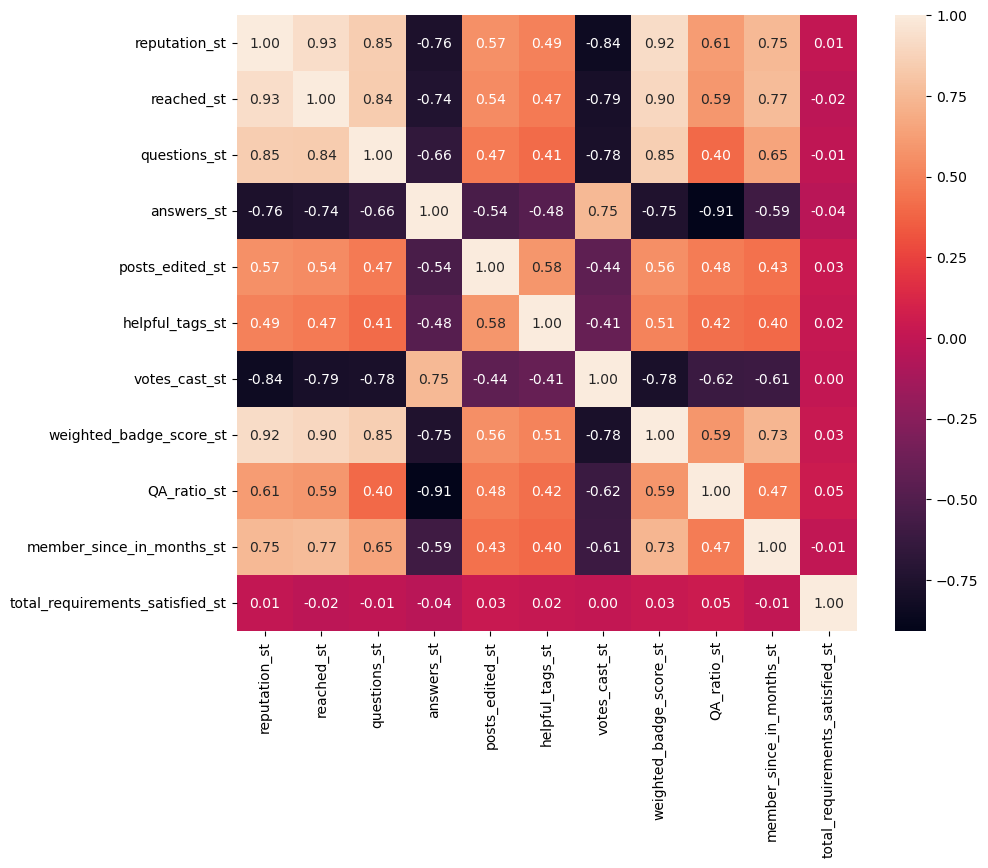

In [22]:
corr_matrix = df_train[st_columns1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

## Modelling

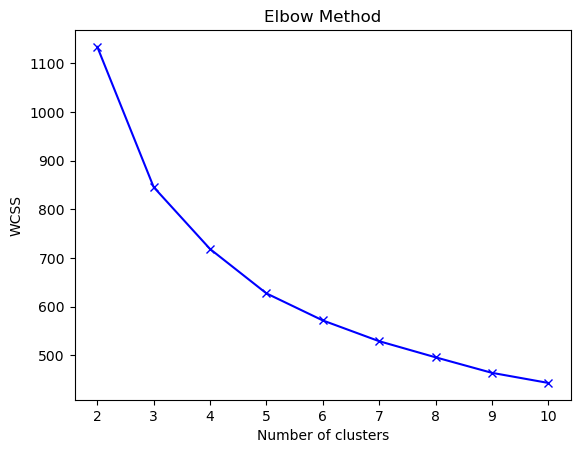

In [24]:
# kmodel.drop(columns='Cluster',inplace=True)
kmodel = df_train.copy()
wcss = []
results = []
silhouette_avgs = []

for i in range(2, 11):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(kmodel[st_columns1])  # X is your data
    wcss.append(kmeans.inertia_)
    silhouette = silhouette_score(kmodel[st_columns1], kmeans.labels_)
    silhouette_avgs.append(silhouette)
    results.append({'Number of Clusters': i, 'WCSS': kmeans.inertia_})
    
elbow_data = pd.DataFrame(results)
    
plt.plot(range(2, 11), wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
elbow_data

Number of Clusters         WCSS
0                   2  1134.001833
1                   3   845.658117
2                   4   718.460806
3                   5   627.215096
4                   6   571.568066
5                   7   528.859536
6                   8   495.763107
7                   9   463.830264
8                  10   443.056839

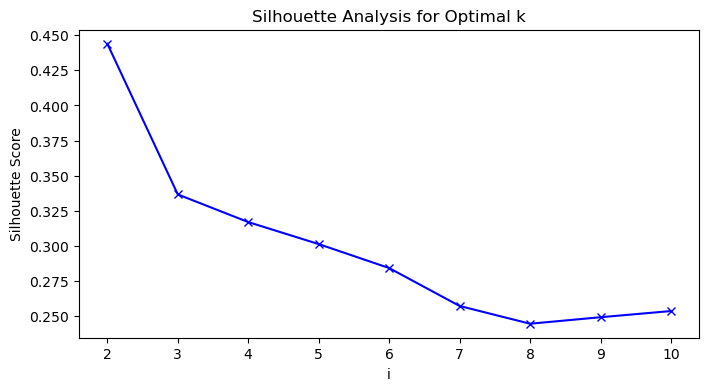

In [26]:
i = range(2, 11) 
plt.figure(figsize=(8, 4))
plt.plot(i, silhouette_avgs, 'bx-')
plt.xlabel('i')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

In [27]:
# kmodel = pd_df[pd_df['total_requirements_satisfied']>=2]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(kmodel[st_columns1])
kmodel['Cluster'] = kmeans.labels_
kmodel_inference = kmodel[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [28]:
kmodel_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0            123.89    14528.28       7.87     1.74          0.07   
1              6.71      474.66       1.82     0.12          0.00   
2           5920.87  1416369.05      76.79    54.65         17.37   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.06       18.74                   57.34   
1                0.01        0.01                   17.85   
2               24.95      546.46                  104.94   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                       18.29      0.63                          2.10  
1                        4.50      0.08                          2.12  
2                      148.69      2.50                          2.13

In [29]:
kmodel_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        2               289
1        0               275
2        1               252

In [29]:
kmodel_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        0               289
1        1               275
2        2               252

# Testing

In [30]:
#Cleaning the data
df_test['name'] = df_test['name'].str.replace('\n','')
df_test['name'] = df_test['name'].str.strip()

#Null Value Imputation
df_test['job_role'].fillna('NA',inplace=True)
df_test['tags'].fillna('NA',inplace=True)
df_test['gold_badges'].fillna('NA',inplace=True)
df_test['silver_badges'].fillna('0',inplace=True)
df_test['bronze_badges'].fillna('0',inplace=True)
df_test['questions'].fillna('0',inplace=True)
df_test['answers'].fillna('0',inplace=True)
df_test['reputation'].fillna('0',inplace=True)
df_test['reached'].fillna('0',inplace=True)
df_test['posts_edited'].fillna('0',inplace=True)
df_test['votes_cast'].fillna('0',inplace=True)
df_test['helpful_tags'].fillna('0',inplace=True)

df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']]=df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

# 2. Clean k and m values
df_test['reached'] = df_test['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_test['reached'] = df_test['reached'].apply(convert_k_to_num)

# 3. Cleaning Member_Since
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_test['member_since_in_months'] = df_test['member_since'].apply(convert_to_months)
df_test['member_since_in_months'] = df_test['member_since_in_months'].round(2)

#Type Casting
df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

#Feature Engineering
df_test['weighted_badge_score'] = (3 * df_test['gold_badges']) + (2 * df_test['silver_badges']) + df_test['bronze_badges']
df_test['questions'] = np.where(df_test['questions']==0, 1, df_test['questions'])
df_test['QA_ratio'] = (df_test['answers']/df_test['questions']).round(2)

#dropping this because there's a weighted badge score
df_test.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

#Creating flags
df_test['Programming_Language_Flag'] = np.where(df_test['tags'].str.contains('python'),1,0)
df_test['Machine_Learning_Flag'] = np.where(df_test['tags'].str.contains('scikit-learn|statsmodels|machine-learning|regression'),1,0)
df_test['Neural_Network_Flag'] = np.where(df_test['tags'].str.contains('deep-learning|pytorch|keras|tensorflow|neural-networks'),1,0)
df_test['Programming_Language_Flag'] = np.where((df_test['Machine_Learning_Flag']==1)|(df_test['Neural_Network_Flag']==1) , 1, df_test['Programming_Language_Flag'])
df_test['total_requirements_satisfied'] = df_test['Programming_Language_Flag']+df_test['Machine_Learning_Flag']+df_test['Neural_Network_Flag']

#Shortlisting Candidates with Valid Skill
df_test = df_test[~(((df_test['total_requirements_satisfied']==1)&(df_test['Programming_Language_Flag']==1))|(df_test['total_requirements_satisfied']==0))]

#Transformations
df_test['reputation_st'],rep = st.boxcox(df_test['reputation']+1)
df_test['reached_st'],reach = st.boxcox(df_test['reached']+1)
df_test['questions_st'],ques = st.boxcox(df_test['questions']+1)
df_test['answers_st'] = 1/(df_test['answers']+1)
df_test['posts_edited_st'],post = st.boxcox(df_test['posts_edited']+1)
df_test['helpful_tags_st'],help = st.boxcox(df_test['helpful_tags']+1)
df_test['votes_cast_st'] = 1/(df_test['votes_cast']+1)
df_test['weighted_badge_score_st'],badge = st.boxcox(df_test['weighted_badge_score']+1)
df_test['QA_ratio_st'] = df_test['QA_ratio']**0.2

#Scaling with Robust Scaler
st_columns = [i for i in df_test.columns if i.endswith('_st')]
scaler = RobustScaler()
df_test[st_columns] = scaler.fit_transform(df_test[st_columns])
scaled2 = scaler.fit_transform(df_test[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_test.index)
df_test = pd.concat([df_test, df_scaled2], axis=1)
st_columns1 = [i for i in df_test.columns if i.endswith('_st')]

df_test['Cluster'] = kmeans.predict(df_test[st_columns1])
testing_inference = df_test[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [31]:
testing_inference.groupby('Cluster').mean().round(2)

reputation    reached  questions  answers  posts_edited  \
Cluster                                                            
0             55.93    6809.49       5.12     0.61          0.00   
1              3.86      94.78       1.45     0.01          0.00   
2           2145.55  520403.85      43.84    26.46          8.33   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.02        4.01                   39.84   
1                0.00        0.00                    8.55   
2                8.95      305.59                   90.18   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                       12.54      0.23                          2.13  
1                        2.51      0.01                          2.14  
2                       83.26      1.32                          2.09

In [39]:
testing_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        1                70
1        2                57
2        0                52

In [32]:
testing_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        2               104
1        0                82
2        1                74

# Validation

In [33]:
from sklearn.metrics import silhouette_score

# Combine the training and testing data for a comprehensive silhouette analysis
combined = np.vstack((kmodel[st_columns1], df_test[st_columns1]))
clusters_combined = np.concatenate((kmodel['Cluster'], df_test['Cluster']))

# Compute the silhouette score
silhouette_avg = silhouette_score(combined, clusters_combined)
print('Combined Silhouette Score:', silhouette_avg)

Combined Silhouette Score: 0.31562360843681386


## Storing it to pickle file

In [35]:
dir_path = './model_pickle_files'

# Define the complete file path including the name of the pickle file
file_path = os.path.join(dir_path, 'ai-engineer-model.pkl')

# Ensure the directory exists, create if it doesn't
os.makedirs(dir_path, exist_ok=True)

# Save the model as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(kmeans, file)

print(f"Model saved successfully at {file_path}")

Model saved successfully at ./model_pickle_files/ai-engineer-model.pkl
